# <center> Data Analysis and Machine Learning FYS-STK3155/FYS4155 
# <center> Project 1  
# <center> Isabella Rositi 

## EXERCISE 0: Introducing the Data

We are now going to import all of the libraries that we're going to use in this project.
Moreover, we create two covariates $x, y \in [0,1]$  from a uniform distribution and we use them to compute our response variable $z$ using the Franke Function, which is a two-dimensional function that has been widely used when testing various interpolation and fitting algorithms.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import tqdm
import pingouin as pg

from IPython.display import display
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from random import random, seed
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from time import time
from scipy.stats import norm
from pylab import plt, mpl
from imageio import imread

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'


x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

z = FrankeFunction(x, y) 

Let's now plot the surface

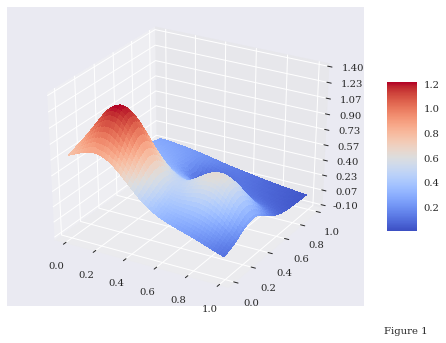

In [4]:
fig = plt.figure()
ax = fig.gca(projection="3d")

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))

fig.text(0.78, 0.05, 'Figure 1', va="bottom", size = "medium")

fig.colorbar(surf, shrink=0.5, aspect=5)

And now let's define the functions that we're going to use throughout the project.

$R^2$ is used to calculate the goodness of fit and it represents the percentage of variance explained by the model. A perfect fit equals to 1 (100%). If its value is negative, then it means that a null model explains more variability then the model in question.  
It is calculated as:

$$R^2(\hat{y}) = 1 - \frac{\sum_{i=0}^{n-1}({y_i - \hat{y_i})^2}}{\sum_{i=0}^{n-1}({y_i - \bar{y_i})^2}}$$

where $\hat{y}$ is the predicted value of $y$ for that specific model.

The $MSE$ (Mean Square Error) is calculated as:

$$MSE(\hat{y}) = \frac{1}{n}\sum_{i=0}^{n-1}({y_i - \hat{y_i})^2}$$

and it represents the error commited by the model. It calculates the distance between the real values and the predictions.

The Standard Error $se$ is used to express the deviation of the values around the prediction value. A high $se$ means that the values are spread out around the prediction, whereas a small $se$ indicates that the real values concentrate around the predictions.  
It is calculated as:

$$se = S\sqrt{(X^TX)^{-1}_{jj}}$$ 

where S is equal to: 

$$S = \frac{1}{n - p}\sum_{i=0}^{n-1}({y_i - \hat{y_i})^2}$$ with $n$ number of rows and $p$ number of columns

The confidence intervals are found using the standard error of the parameters $\hat{\beta}$:  

$$\beta_{inf} = \hat\beta_j - z_{\frac{\alpha}{2}}S\sqrt{(X^TX)^{-1}_{jj}}$$ 
$$\beta_{sup} = \hat\beta_j + z_{\frac{\alpha}{2}}S\sqrt{(X^TX)^{-1}_{jj}}$$ 

where $z_{\frac{\alpha}{2}}$ is the $\frac{\alpha}{2}th$ quantile of the normal standard distribution. If we want confidence intervals at the 95%, then  $z_{\frac{\alpha}{2}}=1.96$.

In [5]:
def R2(y_data, y_model):
    return 1 - np.mean((y_data - y_model) ** 2) / np.mean((y_data - np.mean(y_data)) ** 2)

def MSE(y_data, y_model):
    return np.mean((y_data-y_model)**2)

def sefunction(y, X, beta):
    s = np.sum((y - X @ beta)**2)/(X.shape[0] - X.shape[1])
    varcov = s*(np.linalg.inv(X.T.dot(X)))
    st_err = np.sqrt(np.diag(varcov))
    return(st_err)

def conffunction(beta, st_er):
    c = np.zeros((len(beta), 2))
    for i in range (0,(len(beta)-1)):
            int_l = beta[i] - 1.96*st_er[i]
            int_u = beta[i] + 1.96*st_er[i]
            c[i,0] = int_l
            c[i, 1] = int_u
    return(c) 

## EXERCISE 1: Ordinary Least Square (OLS) on the Franke Function 

We'll now set up or design matrix $X5$, split it in training and test set with a percentage of $80\% - 20\%$ observations each and then we'll proceed to perform a Ordinary Least Square (OLS) regression using polynomials in $x$ and $y$ up to the fifth order. 
We'll then evaluate the $MSE$ and $R^2$ of the model to analyze its goodness and then find the confidence intervals for the $\beta$ parameters.

### Ordinary Least Squares Regression

When we estimate a regression addictive model, we have an equation in the form of: 
$$y_i = \beta_0 + \beta_1x_{i1}+ ... +\beta_px_{ip} + \epsilon_i$$
or in matrix annotation:
$$\textbf{y} = \textbf{X}{\beta}$$
where $\textbf{y}$ is the vector of the response variable, $\textbf{X}$ is the design matrix and $\beta$ is the vector with the model parameters.

We make some hypothesis:

* the design matrix  $\textbf{X}$ of covariates has to have full rank, which means that $n \ge p$, with $n$ number of rows and $p$ number of columns
* the error $\epsilon_i$ is a random variable with expected value $E[\epsilon] = 0$ and variance $Var(\epsilon_i) = \sigma_i^2$, $\forall i$
* the errors follow a normal distribution and are independent

In order to estimate the $\beta$ parameters, the Ordinary Least Squares (OLS) method minimizes o-called Cost Function:

$$\hat{\beta} = {\underset{\boldsymbol{\beta }}{\operatorname{arg\,min}}}\bigg[\frac{1}{n}\sum_{i=0}^{n-1}{(y_i−\sum _{j=1}^{p}X_{ij}\beta _{j}})^2\bigg]$$

which leads to:

$$\hat{\beta} = (\textbf{X}^{T}\textbf{X})^{-1}\textbf{X}^{T}y$$

In order to get the predicted values, we will have to: 

$$\hat{y} = \textbf{X}\hat{\beta} = \textbf{X}(\textbf{X}^{T}\textbf{X})^{-1}\textbf{X}^{T}y$$ 

In [6]:
np.random.seed(1818)
n = 100
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y) + 0.001*np.random.standard_normal(n)

X = np.stack((x, y), axis = -1)
poly5 = PolynomialFeatures(degree = 5)
X5 = poly5.fit_transform(X)

np.random.seed(907)
X5_train, X5_test, z5_train, z5_test = train_test_split(X5, z, test_size=0.2)

Let's first perform linear regression using the Ordinary Least Squares method without scaling our data

In [7]:
beta5 = np.linalg.inv(X5_train.T.dot(X5_train)).dot(X5_train.T).dot(z5_train)
ztilde5 = X5_train @ beta5
zpred5 = X5_test @ beta5

G = np.hstack((R2(z5_train, ztilde5), R2(z5_test, zpred5)))
G = pd.DataFrame(G)              
G.columns = ["R2 - OLS"]
G.index = ["Training", "Test"]
G["MSE - OLS"] = [MSE(z5_train, ztilde5), MSE(z5_test, zpred5)]

And now let's scale the data and see if it's more convenient. We have to point out, however, that our covariates are generated from a uniform distribution and have a range of $[0,1]$, so they already have the same magnitude and also their variance is contained. We would need further anylysis (for example the analysis of the residuals) to affirm if the scaling of the data is needed.

,R2 - OLS,MSE - OLS,R2 - OLS (scaled),MSE - OLS (scaled)
Training,0.981733,0.001369,0.981733,0.018267
Test,0.973623,0.001609,0.973623,0.021474


Text(2.51, -2.3, 'Figure 2')

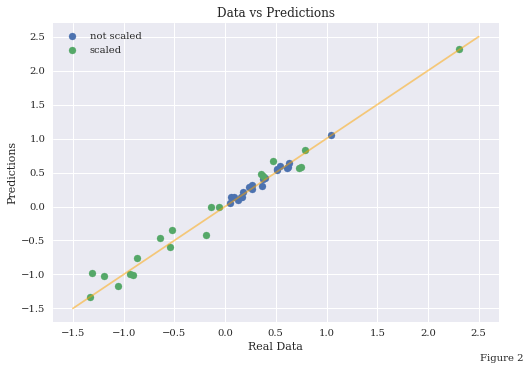

In [8]:
scaler = StandardScaler()
scaler.fit(X5_train[:,1:21])
X5_train_scaled = scaler.transform(X5_train[:,1:21])
X5_test_scaled = scaler.transform(X5_test[:,1:21])

z5_train = z5_train.reshape(80, 1)
z5_test = z5_test.reshape(20, 1)

scaler.fit(z5_train)
z5_train_scaled = scaler.transform(z5_train)
z5_test_scaled = scaler.transform(z5_test)

beta5_scaled = np.linalg.inv(X5_train_scaled.T.dot(X5_train_scaled)).dot(X5_train_scaled.T).dot(z5_train_scaled)
ztilde5_scaled = X5_train_scaled @ beta5_scaled
zpred5_scaled = X5_test_scaled @ beta5_scaled

G["R2 - OLS (scaled)"] = [R2(z5_train_scaled, ztilde5_scaled), R2(z5_test_scaled, zpred5_scaled)]
G["MSE - OLS (scaled)"] = [MSE(z5_train_scaled, ztilde5_scaled), MSE(z5_test_scaled, zpred5_scaled)]
display(G)

plt.scatter(z5_test, zpred5, label="not scaled")
plt.plot([-1.5, 2.5],[-1.5, 2.5], c = "orange", alpha = 0.5)
plt.scatter(z5_test_scaled, zpred5_scaled, label= "scaled")
plt.xlabel("Real Data")
plt.ylabel("Predictions")
plt.title("Data vs Predictions")
plt.legend()
plt.text(2.51, -2.3, 'Figure 2', va="bottom", size = "medium")

We see that the model we estimated using unscaled and scaled data presents the same fit, $R^2 = 97,3\%$, since we scaled both the covariates and the target variable, however, we can also clearly see that the scaled data present a wider range and their variance is obviously bigger.

In [9]:
print("Variance Unscaled Data:", np.var(z5_test))
print("Variance Scaled Data:", np.var(z5_test_scaled))

Variance Unscaled Data: 0.06099867327554435
Variance Scaled Data: 0.814116043256659


Also by looking at the $MSE$ we can see that the unscaled model produces a smaller error than the scaled model (0.0016 versus 0.0125), meaning that the predictions are "closer" to the real observations in the first case rather than in the second. 
Since the unscaled data have already such a good fit, have a smaller variance and smaller $MSE$, and also beacuse the covariates have already the same range, it is better to continue the analysis with unscaled data. 

### Confidence Intervals
Now let's calculate the $95\%$ confidence intervals.

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Lower,-34.181649,-345.911641,-232.912850,-1630.169621,-1090.641020,-1072.630100,-2997.799450,-2057.587275,-2064.637058,-2340.908640,...,-2394.816715,-2025.407610,-2104.498029,-2532.117448,-1017.159975,-966.345607,-861.966124,-808.895096,-831.708153,0.000000
Beta,-0.524802,16.940120,8.791425,-69.298539,-35.176929,-26.338667,106.705325,95.645671,38.659765,28.861205,...,-106.306820,-34.360123,-37.086723,-8.714508,13.300998,38.221502,22.031006,0.700558,17.422508,-1.855979
Upper,33.132044,379.791882,250.495701,1491.572543,1020.287163,1019.952767,3211.210100,2248.878616,2141.956588,2398.631049,...,2182.203076,1956.687363,2030.324582,2514.688432,1043.761972,1042.788612,906.028136,810.296211,866.553170,0.000000
Se,17.171860,185.128450,123.318508,796.362797,538.502088,533.822160,1583.931008,1098.588238,1073.110624,1209.066247,...,1167.607090,1015.840554,1054.801687,1287.450480,525.745395,512.534239,451.018944,413.059007,433.229929,511.452036


Text(0.89, 0.03, 'Figure 3')

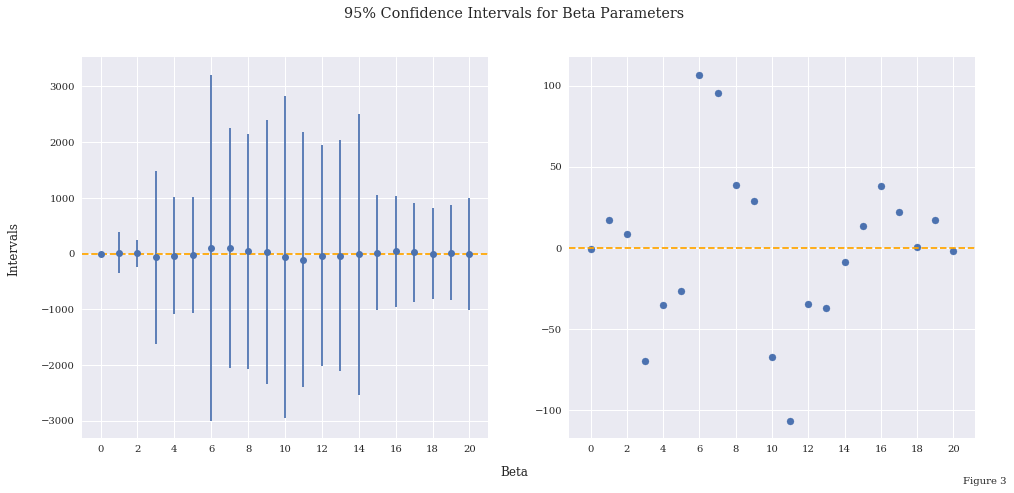

In [10]:
se = sefunction(z5_train, X5_train, beta5)
interval = conffunction(beta5, se)
IN = np.vstack((interval[:, 0], beta5, interval[:, 1], se))
IN = pd.DataFrame(IN)              
IN.index = ["Lower", "Beta", "Upper", "Se"] 
IN.columns = np.arange(0, 21)
display(IN)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('95% Confidence Intervals for Beta Parameters', size = "x-large")

ax1.set_xticks(np.arange(0, 21, 2))
ax1.axhline(np.mean(beta5), c = "orange", linestyle = "--")
ax1.errorbar(x = np.arange(0, 21, 1), y = beta5, yerr = (1.96*se), fmt='o')

ax2.set_xticks(np.arange(0, 21, 2))
ax2.axhline(np.mean(beta5), c="orange", linestyle= "--")
ax2.scatter(np.arange(0, 21, 1), beta5)

fig.text(0.5, 0.05, 'Beta', ha='center', size = "large")
fig.text(0.06, 0.5, 'Intervals', va='center', rotation='vertical', size = "large")
fig.text(0.89, 0.03, 'Figure 3', va="bottom", size = "medium")

We can see that, with an exeption for the first parameters, all of them have very big variance, which results in extremely large intervals, hence very small accuracy when it comes to predict the exact $\beta$ value. let's look at the third parameter: 
$\hat{\beta_3} = - 69.3$ but its $95\%$ confidence interval is: 
$$\hat{\beta_3} \in [- 1630.2; 1491.6]$$
This means that in $95\%$ ofthe cases $\hat{\beta_3}$ will fall into that interval, but as we can see it is pretty big, so this doesn't give us much certainty. 
We also point out that the intercept is very close to zero with a value of -0.52, whereas there are some other parameters with very high values, which have a bigger impact on the model.

## Exercise 2: Bias-Variance Trade-Off and Resampling Techniques

### Training Error and Test Error

When building a model it is important not to overfit. This means that the model shouldn't be explaining perfectly just the training set of data, but it should also be able to explain the test set, namely data that have not been used to fit the model itself.
We compute and plot the two different error values to make sure not to choose a model that overfits (or that underfits). This usually happens as the complexity of the model increases.

In [11]:
maxdegree = 11
TE = np.zeros((maxdegree, 2))
deg = np.arange(1, 11)

np.random.seed(1821)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

for degree in range(1,maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    clf = model.fit(X_train,z_train)
    ztilde = clf.predict(X_train)
    zpred = clf.predict(X_test) 
    TE[degree, 0] = MSE(z_train, ztilde)
    TE[degree, 1] = MSE(z_test, zpred)

TE = pd.DataFrame(TE)
TE.columns = ["TrainingError", "TestError"]
TE = TE.drop(0)
TE.indexes = np.arange(0, 11)
TE = TE.round(3)                    
display(TE)

C:\Users\isabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,TrainingError,TestError
1,0.016,0.020
2,0.012,0.016
3,0.006,0.009
4,0.003,0.005
5,0.001,0.003
6,0.000,0.005
7,0.000,0.024
8,0.000,0.009
9,0.000,0.261
10,0.000,0.407


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


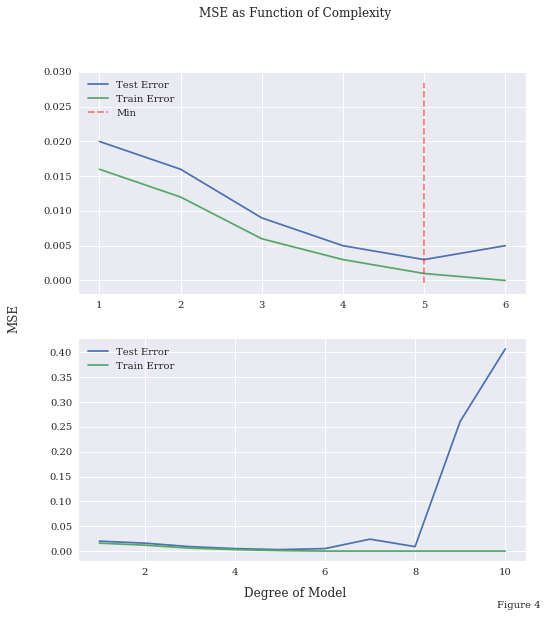

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 9))
fig.suptitle('MSE as Function of Complexity')

ax1.plot(deg[0:6], TE.iloc[0:6, 1], label='Test Error')
ax1.plot(deg[0:6], TE.iloc[0:6, 0], label='Train Error')
ax1.axvline(x = TE["TestError"].idxmin(), c= "red", linestyle = "--", alpha = 0.5, 
            ymin = 0.05, ymax = 0.95, label = "Min")
ax1.set_ylim(-0.002, 0.03)

ax2.plot(deg, TE["TestError"], label='Test Error')
ax2.plot(deg, TE["TrainingError"], label='Train Error')

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "large")
fig.text(0.0001, 0.5, 'MSE', va='center', rotation='vertical', size = "large")
fig.text(0.85, 0.05, 'Figure 4', va="bottom", size = "medium")

ax1.legend(loc = "upper left")
ax2.legend()    

We can clearly see that the minimum value for the test error (which is always larger than the training error) is found at the fifth degree model, even if the training error still lowers as the complexity increases. Before that point the errors are larger because the model is too simple to explain properly the data (underfit) and after that we have the test error increasing again and the training error going towards zero. This happens because as the complexity increases, the model becomes too specific for the training set (and we can see this in the small training error) and it can't explain data which have not been used to estimated it (and we can see this in the large test error).

### Bias-Variance Trade-Off

By using the ordinary least squares method we find the parameters $\beta$ by optimizing the $MSE$ using the so-called Cost Function:

$$C(X,\beta) = \frac{1}{n}\sum_{i=0}^{n-1}{(y_i−\hat{y_{i}})^2} = E[(y−\hat{y})^2]$$

which we can also rewrite as:

$$E[(y−\hat{y})^2] = E[(f + \epsilon - \hat{y})^2]$$

where $y = f + \epsilon$ being $\epsilon$ the noise.  
From here we add and subtract the same quantity:  

$$E[(y−\hat{y})^2] = E\big[[(y - E[\hat{y}]) + (E[\hat{y}] - \hat{y}) + \epsilon]^2\big] = \\ = E\big[(y - E[\hat{y}])^2 + (E[\hat{y}] - \hat{y})^2 + \epsilon^2 + 2(y - E[\hat{y}]) (E[\hat{y}] - \hat{y}) + 2\epsilon(y - E[\hat{y}]) + 2\epsilon(E[\hat{y}] - \hat{y})\big]$$

where

$$E\big[(E[\hat{y}] - \hat{y})\big] = E[\hat{y}] - E[\hat{y}] = 0$$

and

$$E[\epsilon] = 0$$

which leads to

$$Var(\epsilon) = \sigma^2 = E[\epsilon^2] - (E[\epsilon])^2 = E[\epsilon^2] $$

so the Cost Function can be rewritten as:

$$E[(y−\hat{y})^2] = E\big[[(y - E[\hat{y}]) + (E[\hat{y}] - \hat{y})^2\big] = \\ = E\big[(y - E[\hat{y}])^2 + (E[\hat{y}] - \hat{y})^2 + \epsilon^2\big] = \\ = E\big[(y - E[\hat{y}])^2\big] + E\big[(E[\hat{y}] - \hat{y})^2\big] + E\big[\epsilon^2\big]  = \\ = E\big[(y - E[\hat{y}])^2\big] + Var(\hat{y}) + \sigma^2$$

At the end we have:

$$E[(y−\hat{y})^2] = E\big[(y - E[\hat{y}])^2\big] + Var(\hat{y}) + \sigma^2 = bias^2 + variance + irreducible\space error$$

#### Bias Error

The bias error is the difference between the real value that we're trying to predict and the average prediction of our model.  
It is given by all the assumptions made by our model to simplify the learning of the target function.  
This means that if there's high bias we oversimplify model assumptions about the form of the target function, which means that the model pays very little attention to the training set used. 

#### Variance Error

The variance is the variability of the model prediction for a given data point or a value which indicates how much spread our data is. It shows how much the target function will change if a different training set was used.  
This means that if there's high variance the model doesn't generalize on the data which it has not seen before, which means that it will perform very well on the training data, but it will have high error rates on the test data.

So we should expect our model to have some variance, but it should not change too much from one training set to the other, meaning that it is good at picking out the hidden underlying mapping between the variables.

#### Irrudicible Error

Irreducible error is irrelevant for the underlying model and it is inherent to the noise in the data, which can be due to bad data quality, approximate knowledge of the true function, or in general, any type of noise that cannot be easily defined.   
This error can’t be reduced by creating good models, no matter how good we make our model, our data will have a certain amount of noise that can not be removed.

#### Aim
Our goal is to build a model that achieves a balance between bias and variance so that the combined error of these two is minimum.
When our model suffers from high bias and low variance, the average response of the model is far from the true value and we call this *underfitting*, which happens when a model is unable to capture the underlying pattern of the data. This can happen when we have very little data to build an accurate model or when we try to build a linear model with nonlinear data.  
On the other hand, *overfitting* happens when our model also captures the noise along with the underlying pattern in the data. It happens when we train our model over noisy dataset. These models have low bias and high variance and tend to be very complex.

If our model is too simple and has very few parameters then it may have high bias and low variance. On the other hand if our model has a large number of parameters then it’s going to have high variance and low bias. So we need to find the right balance without overfitting nor underfitting the data.

### OLS with Bootstrap Resampling

Bootstrapping is one of the resampling techniques, which are methods used to have more accurate results in different types of analysis. Bootstrap is widely used, especially when:  

* the sample size is small and the division in training and test set can't provide accurate results
* the is complex, such as data-collection plans (stratified and clustered samples)
* the data distribution is unkown or difficult to derive

The idea behind the Bootstrap method is to estimate the pdf of $\hat{\beta}$ using its relative frequency. If the relative frequency closely resembles the pdf, then we can estimate all the interesting parameters of the distribution.

The steps of the Bootstrap method are:

* draw with replacement $n$ times $x_i$ from the observed variables $x = (x_1, x_2 ,⋯, x_n)$.
* define a vector $x^*$ containing the values which were drawn from $x$
* using the vector $x^*$ compute $\hat{\beta^*}$ by evaluating $\hat{\beta}$ under the observations $x^*$
* repeat this process k times

The final histogram of the relative frequency of  $\hat{\beta^*}$ is the estimate of the probability distribution of $\hat{\beta}$. Using this probability distribution we can then estimate any statistics.   
In rality we never draw the histogram of the relative frequency of $\hat{\beta^*}$, instead we use the estimators corresponding to the statistic of interest. For example, if we are interested in estimating the variance of $\hat{\beta^*}$, we apply the etsimator $\sigma^2$ to the values $\hat{\beta^*}$.

Let's now calculate and plot the $MSE$ using the Bootstrap resampling method and perform an analysis of the bias-variance trade-off.

In [13]:
np.random.seed(702)
n_boostraps = 100
maxdegree = 11
z_test = z_test.reshape(20,1)
B = np.zeros((maxdegree, 3))

zpred_b = np.zeros((z_test.shape[0], n_boostraps)) 
    
for degree in range(1,maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    
    for i in range(n_boostraps):
        x_, y_ = resample(X_train, z_train)
        zpred_b[:, i] = model.fit(x_, y_).predict(X_test).ravel()
    B[degree, 0] = format(np.mean(np.mean((z_test - zpred_b)**2, axis=1, keepdims=True) ), ".3f")
    B[degree, 1] = format(np.mean((z_test - np.mean(zpred_b, axis=1, keepdims=True))**2 ), ".3f")
    B[degree, 2] = format(np.mean(np.var(zpred_b, axis=1, keepdims=True) ), ".3f")

B = pd.DataFrame(B)
B.columns = ["Error - OLS", "Bias - OLS", "Variance - OLS"]
B = B.drop(0)
B.indexes = np.arange(1, 11)         
display(B.round(3))

C:\Users\isabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,Error - OLS,Bias - OLS,Variance - OLS
1,0.021,0.020,0.001
2,0.019,0.017,0.002
3,0.010,0.009,0.001
4,0.013,0.006,0.007
5,0.025,0.007,0.018
6,0.043,0.004,0.040
7,0.733,0.087,0.646
8,18.649,0.179,18.470
9,35.833,0.203,35.629
10,32.688,0.233,32.455


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


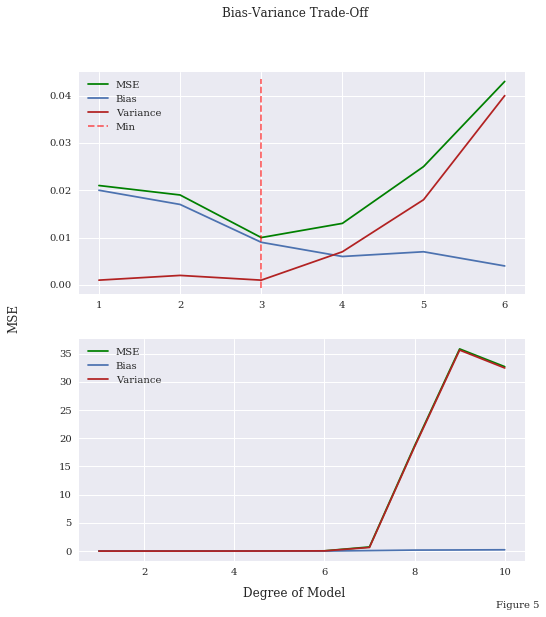

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,9))
fig.suptitle('Bias-Variance Trade-Off')

ax1.plot(deg[0:6], B.iloc[0:6, 0], label='MSE', c = "green")
ax1.plot(deg[0:6], B.iloc[0:6, 1], label='Bias')
ax1.plot(deg[0:6], B.iloc[0:6, 2], label='Variance', c = "firebrick")
ax1.axvline(x = B["Error - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax1.set_ylim(-0.002, 0.045)

ax2.plot(deg, B["Error - OLS"], label='MSE', c = "green")
ax2.plot(deg, B["Bias - OLS"], label='Bias')
ax2.plot(deg, B["Variance - OLS"], label='Variance', c = "firebrick")

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "large")
fig.text(0.001, 0.5, 'MSE', va='center', rotation='vertical', size = "large")
fig.text(0.85, 0.05, 'Figure 5', va="bottom", size = "medium")

ax1.legend()
ax2.legend()   

We can see that if we apply the bootstrap resampling technique the best model is the model of third degree beacuse it has the lowest $MSE$, which splits into a very low bias and variance. This means that if we were to use a different training set, the model wouldn't suffer from any relevant changes. Moreover we see how the variance, and consequently the error, increases abruptly after the seventh degree polynomial. This is a clear example of overfitting, where we have very low bias and very high variance, which results into having complex models that change a lot based on the training sets used to estimate them.

The results we get are different from the previous ones (in Figure 4) beacuse now we have used a resampling technique (bootstrap), which should provide with more reliable results, since it's like we have 100 different training and test sets and we compute our statistics for every one of them and then compute a mean. 

## EXERCISE 3: Cross-Validation

Cross-Validation is another one of the resampling methods, and it is very used to both evaluate the performance of a model and to select the appropriate level of complexity.

When we perform other types of resampling techniques, the repetitive splitting of the data set is done randomly, and samples may accidently end up in a majority of the splits in either training or test set. Such samples will result then to have an unbalanced influence on either model building or prediction evaluation. To avoid this, the $k$-fold Cross-Validation follows a structured splitting of the data. The samples are divided into $k$ equally sized and mutually exclusive subsets. At turn, each of the subsets will be the test set and the others will constitute the training set. This operation is repeated $k$ times, until all of the subsets have been once the test set. Such a splitting guarantees a balanced representation of each sample in both training and test set over the splits. Still the division into the $k$ subsets involves a degree of randomness.
As in the Bootstrap, in the end we will have $k$ different statistics, of which we'll calculate the mean and have a final statistic that is more accurate, since we had $k$ training and test sets and not just one. 

,MSE_5fold - OLS,MSE_10fold - OLS
1,0.017,0.018
2,0.015,0.016
3,0.008,0.008
4,0.007,0.007
5,0.004,0.004
6,0.006,0.010
7,0.077,0.032
8,0.023,0.049
9,3.441,0.487
10,21.944,2.338


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


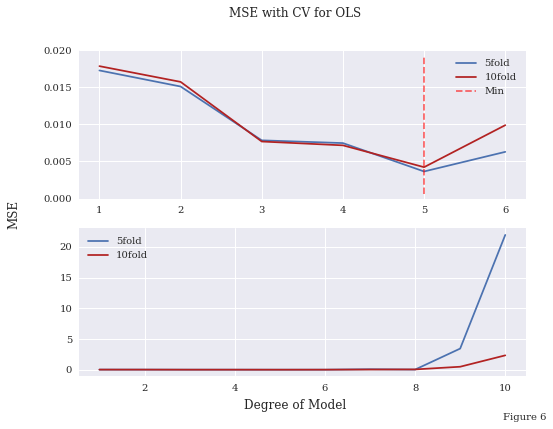

In [15]:
maxdegree = 11
scaler = StandardScaler(with_std = True)
scaler.fit(X)
X_scaled = scaler.transform(X)
CV = np.zeros((maxdegree, 2))

kfold5 = KFold(n_splits = 5)
kfold10 = KFold(n_splits = 10)
scores5 = np.zeros((maxdegree, 5))
scores10 = np.zeros((maxdegree, 10))

for degree in range(1, maxdegree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    lin_reg = LinearRegression()
    j = 0
    for train_inds, test_inds in kfold5.split(X_scaled):
        xtrain = X_scaled[train_inds, :]
        ztrain = z[train_inds]

        xtest = X_scaled[test_inds, :]
        ztest = z[test_inds]

        X_train_scaled = poly.fit_transform(xtrain)
        lin_reg.fit(X_train_scaled, ztrain)
        
        X_test_scaled = poly.fit_transform(xtest)
        zpred_cv = lin_reg.predict(X_test_scaled)

        scores5[degree, j] = MSE(zpred_cv, ztest)

        j += 1

estimated_mse5 = np.mean(scores5, axis = 1)

CV = pd.DataFrame(CV)
CV.iloc[:, 0] = estimated_mse5
CV.columns = ["MSE_5fold - OLS", "MSE_10fold - OLS"]
CV = CV.drop(0)
CV.index = np.arange(1, 11)

for degree in range(1, maxdegree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    lin_reg = LinearRegression()
    j = 0
    for train_inds, test_inds in kfold10.split(X_scaled):
        xtrain = X_scaled[train_inds, :]
        ztrain = z[train_inds]

        xtest = X_scaled[test_inds, :]
        ztest = z[test_inds]

        X_train_scaled = poly.fit_transform(xtrain)
        lin_reg.fit(X_train_scaled, ztrain)
        
        X_test_scaled = poly.fit_transform(xtest)
        zpred_cv = lin_reg.predict(X_test_scaled)

        scores10[degree, j] = MSE(zpred_cv, ztest)

        j += 1

estimated_mse10 = np.mean(scores10, axis = 1)

CV["MSE_10fold - OLS"] = estimated_mse10[1:11]
display(CV.round(3))  

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,6))
fig.suptitle('MSE with CV for OLS')

ax1.plot(deg[0:6], CV.iloc[0:6, 0], label = "5fold")
ax1.plot(deg[0:6], CV.iloc[0:6, 1], label = "10fold", c = "firebrick")
ax1.axvline(x = CV["MSE_10fold - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax1.set_ylim(0, 0.02)

ax2.plot(deg, CV["MSE_5fold - OLS"], label = "5fold")
ax2.plot(deg, CV["MSE_10fold - OLS"], label = "10fold", c = "firebrick")

fig.text(0.5, 0.05, 'Degree of Model', ha='center', size = "large")
fig.text(0.0001, 0.5, 'MSE', va='center', rotation='vertical', size = "large")
fig.text(0.86, 0.02, 'Figure 6', va="bottom", size = "medium")

ax1.legend()
ax2.legend() 

We just performed a Cross-Validation estimating the $MSE$ for each model going up to the tenth degree, and we can see that for the models up to eighth degree the two different approaches (5-fold and 10-fold) give pretty much the same results, whereas starting from the eighth degree model the 5-fold Cross-Validation gives $MSE$ values noticebly bigger than the 10-fold Cross-Validation. Both of them, anyways, suggest the same model as the best one, which end up being the fifth degree model.

,MSE Bootstrap - OLS,MSE_5fold - OLS,MSE_10fold - OLS
1,0.021,0.017,0.018
2,0.019,0.015,0.016
3,0.010,0.008,0.008
4,0.013,0.007,0.007
5,0.025,0.004,0.004
6,0.043,0.006,0.010
7,0.733,0.077,0.032
8,18.649,0.023,0.049
9,35.833,3.441,0.487
10,32.688,21.944,2.338


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


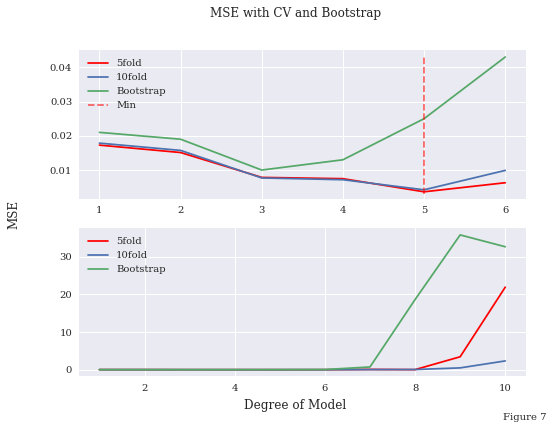

In [16]:
COMP = np.stack((B["Error - OLS"], CV["MSE_5fold - OLS"], CV["MSE_10fold - OLS"]), axis = -1)
COMP = pd.DataFrame(COMP)
COMP = COMP.round(3) 
COMP.columns = ["MSE Bootstrap - OLS", "MSE_5fold - OLS", "MSE_10fold - OLS"]
COMP.index = np.arange(1, 11)   
display(COMP)

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,6))
fig.suptitle('MSE with CV and Bootstrap')

ax1.plot(deg[0:6], CV.iloc[0:6, 0], label = "5fold", c = "red")
ax1.plot(deg[0:6], CV.iloc[0:6, 1], label = "10fold")
ax1.plot(deg[0:6], B.iloc[0:6, 0], label = "Bootstrap")
ax1.axvline(x = COMP["MSE_10fold - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax2.plot(deg, CV["MSE_5fold - OLS"], label = "5fold", c = "red")
ax2.plot(deg, CV["MSE_10fold - OLS"], label = "10fold")
ax2.plot(deg, B["Error - OLS"], label = "Bootstrap")

fig.text(0.5, 0.05, 'Degree of Model', ha='center', size = "large")
fig.text(0.0001, 0.5, 'MSE', va='center', rotation='vertical', size = "large")
fig.text(0.86, 0.02, 'Figure 7', va="bottom", size = "medium")

ax1.legend()
ax2.legend() 

Here we have a comparison between the $MSE$ for each of the models up to tenth degree order that we estimated using three different ways of resampling techniques: 5-fold Cross-Validation, 10-fold Cross-Validation and Bootstrap. Depending on what our necessities and aims in the analysis are, we should use a different resampling method, since the Bootstrap and the Cross-Validation have completely different approches and it is not unlikely for them to provide different outcomes.
In this case, the Bootstrap recognises as best model (the one with the samllest $MSE$, which means the one whose predictions are the closest to the real data) the third degree order model, whereas both the Cross-Validation approches find the fifth degree model to be the best. We can seee, however, that the error that we get applying the Cross-Validation method is smaller than the one using the Bootstrap, for every degree of the model.

## Exercise 4: Ridge Regression on the Franke Function with Resampling

The Ridge Regression adds a regularization parameter $\lambda$ to the Ordinary Least Squares method, that leads to a new Cost-Function to minimize:

$$\hat{\beta}_{Ridge} = {\underset{\boldsymbol{\beta }}{\operatorname{arg\,min}}}\bigg[\frac{1}{n}\sum_{i=0}^{n-1}{(y_i−\sum _{j=1}^{p}X_{ij}\beta _{j}})^2 + \lambda\sum_{j=1}^{p}\beta _{j}^2\bigg]$$

which leads to:

$$\hat{\beta}_{Ridge} = (\textbf{X}^{T}\textbf{X}+ \lambda\textbf{I})^{-1}\textbf{X}^{T}y$$

with the constraint that: 

$$\sum_{i=0}^{p−1}\beta^2_i \leq t$$ 
where $t$ is a finite number larger than zero.  
In order to get the predicted values, we will have to: 

$$\hat{y} = \textbf{X}\hat{\beta}_{Ridge}$$ 

Compared to the parameters that we get using the OLS, the one estimated with the Ridge Regression are scaled by: $$\hat\beta_{Ridge} = \frac{\hat\beta_{OLS}}{\lambda +1}$$
with $\lambda \geq 0$.   
This means that Ridge Regression shrinks the coordinates of $\hat\beta_{OLS}$ and if $\lambda$ goes to infinity, than $\hat\beta_{Ridge}$ tends to zero.

When we use the Ridge Regression our design matrix $\textbf{X}$ doesn't have to have full rank, since we can see that we're adding $\lambda$ to its diagonal before inverting it.

Cross-Validation is widely used to select the tuning parameters, here being $\lambda$ for the Ridge Regression. For each $\lambda \in [10^{-4}, 10^4]$ we compute a 5-fold Cross-Validation and calculate the $MSE$ and for each of the 100 $\lambda$ taken into consideration we look for the one that produces the smallest $MSE$. 

In [17]:
np.random.seed(1818)
n = 100
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y) + 0.001*np.random.standard_normal(n)
X = np.stack((x, y), axis = -1)

nlambdas = 100
lambdas = np.logspace(-4, 4, nlambdas)

maxdegree = 11
k = 5
kfold_r = KFold(n_splits = k)
estimated_mse_r = np.zeros((maxdegree, nlambdas))
bestlambda_r = np.zeros(maxdegree)
mse_r = np.zeros(maxdegree)

for degree in range(1, maxdegree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xft = poly.fit_transform(X)
    scaler = StandardScaler(with_std = True)
    scaler.fit(Xft)
    Xft_scaled = scaler.transform(Xft)
    i = 0
    minim = float("inf")
    for lmb in lambdas:
        ridge = Ridge(alpha = lmb)
        estimated_mse_folds = cross_val_score(ridge, Xft_scaled, z, scoring='neg_mean_squared_error', cv=kfold_r)
        estimated_mse_r[degree, i] = np.mean(- estimated_mse_folds)
        if estimated_mse_r[degree, i] < minim:
            bestlambda_r[degree] = lmb
            minim = estimated_mse_r[degree, i]
            mse_r[degree] = estimated_mse_r[degree, i]
        i += 1
    
LR = np.stack((bestlambda_r, mse_r), axis = -1)
LR = pd.DataFrame(LR)
LR = LR.drop(0)#
LR = LR.round(4) 
LR.columns = ["Best Lambda", "Min MSE"]
LR.index = np.arange(1, 11)   
display(LR)

,Best Lambda,Min MSE
1,0.7565,0.0173
2,0.2057,0.0151
3,0.0221,0.0074
4,0.0014,0.0071
5,0.0001,0.0036
6,0.0001,0.0031
7,0.0001,0.0031
8,0.0001,0.0025
9,0.0003,0.0030
10,0.0008,0.0035


Text(0.5, 0.98, 'Best Lambda for Each Model')

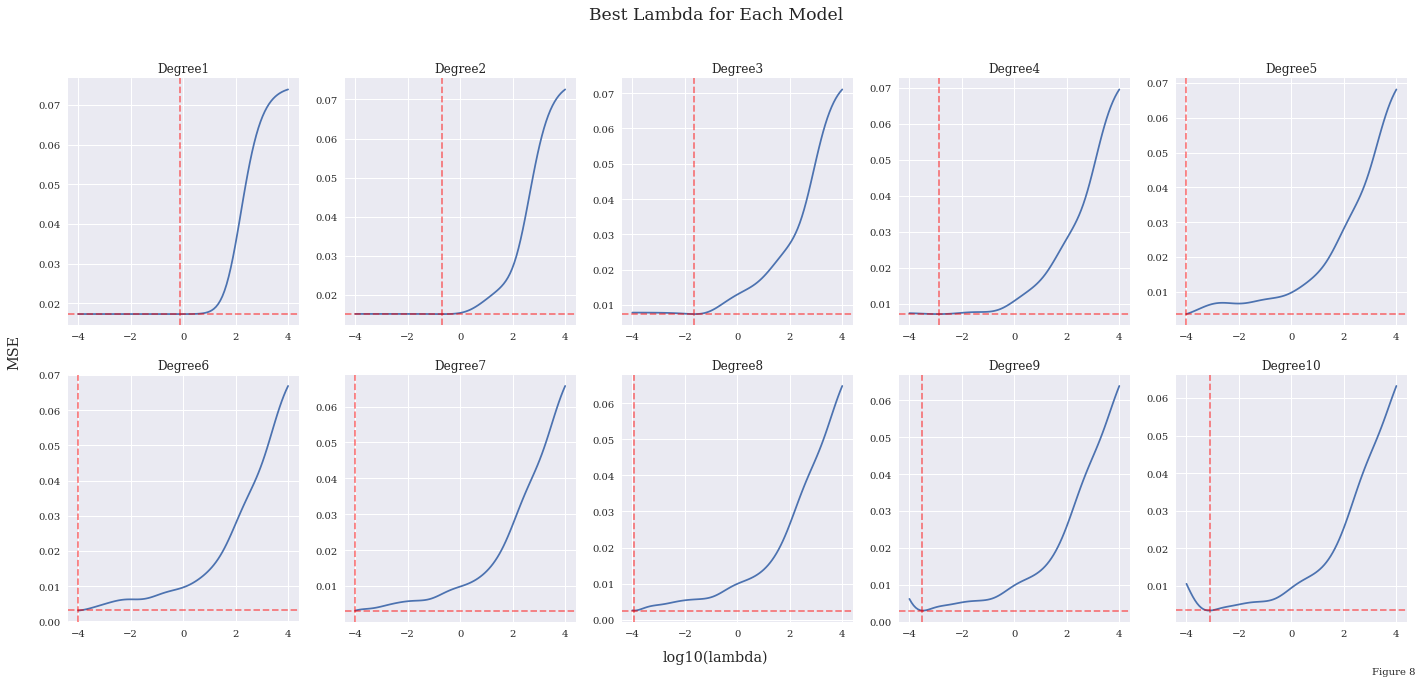

In [18]:
fig, ax = plt.subplots(2,5, figsize=(24, 10))
ax = ax.ravel()
for i in range(1, 11):
    ax[i - 1].plot(np.log10(lambdas), estimated_mse_r[i, :])
    ax[i - 1].axvline(x=(np.log10(bestlambda_r[i])), c= "red", linestyle = "--", alpha = 0.5)
    ax[i - 1].axhline(y = LR.iloc[i-1, 1], c= "red", linestyle = "--", alpha = 0.5)
    ax[i - 1].set_title("Degree" + str(deg[i-1]))
fig.text(0.88, 0.05, 'Figure 8', va="bottom", size = "medium")
fig.text(0.09, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.5, 0.07,'log10(lambda)', ha="center", size = "x-large")
fig.suptitle("Best Lambda for Each Model", size = "xx-large")

Here we have 10 graphics showing the $MSE$ for all of the $\lambda$ values we took into account. We can see that, as the value of $\lambda$ increases, the $MSE$ increases as well, but as the complexity of the model increases, the $MSE$ starts to increase also for very low values of the parameter.  
We know that for higher values of $\lambda$ the paramaters $\beta$ go through a heavier shrinkage, so we have models that don't really fit to the data, since a lot of the parameters are very close to zero. As the complexity increases, however, for very little values of $\lambda$ we have $\beta$ parameters very similar to the ones we get with the Ordinary Least Square Regression, so it means that we have a lot of different parameters and not all of them are essential to obtain a good fit, on the contrary we may end up having a model too specific for the training set, which produces a higher Test Error.

Now let's perform a Ridge Regression on the fifth degree polynomial we already used for the OLS Regression and to do so we use the best $\lambda$ we found for this model with the Cross-Validation: 0.0001

,R2 - OLS,MSE - OLS,R2-Ridge,MSE-Ridge
Training,0.981733,0.001369,0.957118,0.003213
Test,0.973623,0.001609,0.954956,0.002748


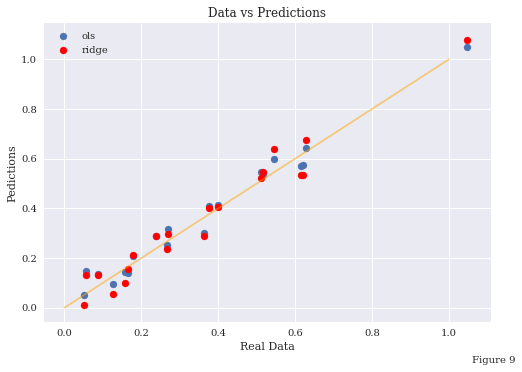

In [19]:
I = np.eye(21,21)
lambda_r = 0.0001
beta5_r = np.linalg.inv(X5_train.T.dot(X5_train)+lambda_r*I).dot(X5_train.T).dot(z5_train)
ztilde5_r = X5_train @ beta5_r
zpred5_r = X5_test @ beta5_r

G["R2-Ridge"] = [R2(z5_train,ztilde5_r), R2(z5_test,zpred5_r)]
G["MSE-Ridge"] = [MSE(z5_train,ztilde5_r), MSE(z5_test,zpred5_r)]
display(G.iloc[:, [0,1,4,5]])

plt.scatter(z5_test, zpred5, label= "ols")
plt.scatter(z5_test, zpred5_r, label="ridge", c="red")
plt.plot([0, 1], c = "orange", alpha = 0.5)
plt.xlabel("Real Data")
plt.ylabel("Pedictions")
plt.title("Data vs Predictions")
plt.text(1.06, -0.23, 'Figure 9', va="bottom", size = "medium")
plt.legend()

If we compare the fit of the model obtained with Ridge to the one obtained with OLS, we can see that we get a slightly worse fit, but nonetheless a very good fit, with $95,5\%$ of the variance of the test set explained by the model. Also from the figure it is noticeable that the predictions made with the Ridge Regression are a little bit further from the bisector of the first and third quadrant than the OLS predictions.

Let's compute the $95\%$ confidence intervals of the $\beta$ parameters and see how much they shrunk compared to the ones we obtained with the OLS regression.

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
Lower,-32.447995,-357.289681,-237.177711,-1554.747331,-1043.225444,-1044.057146,-3064.906402,-2126.772934,-2082.944168,-2340.838967,...,-2268.250226,-1967.995034,-2048.271158,-2490.555955,-1026.717249,-995.195331,-871.897578,-804.782596,-837.648246,0.000000
Beta,0.857398,1.773088,2.002626,-10.175273,1.217215,-8.691362,7.180323,3.975391,-1.610519,4.185122,...,-3.637548,2.261415,-2.448301,6.496953,-7.016618,-1.118174,2.868623,-3.640952,2.615571,-4.615401
Upper,34.162791,360.835857,241.182962,1534.396786,1045.659875,1026.674423,3079.267048,2134.723716,2079.723130,2349.209211,...,2260.975130,1972.517864,2043.374555,2503.549860,1012.684013,992.958983,877.634824,797.500693,842.879388,0.000000
SD,16.992547,183.195290,122.030784,788.046969,532.878908,528.247849,1567.391186,1087.116492,1061.904923,1196.440862,...,1155.414632,1005.232882,1043.787172,1274.006586,520.255424,507.182223,446.309286,408.745737,428.706029,506.111320


Text(22, -170, 'Figure 10')

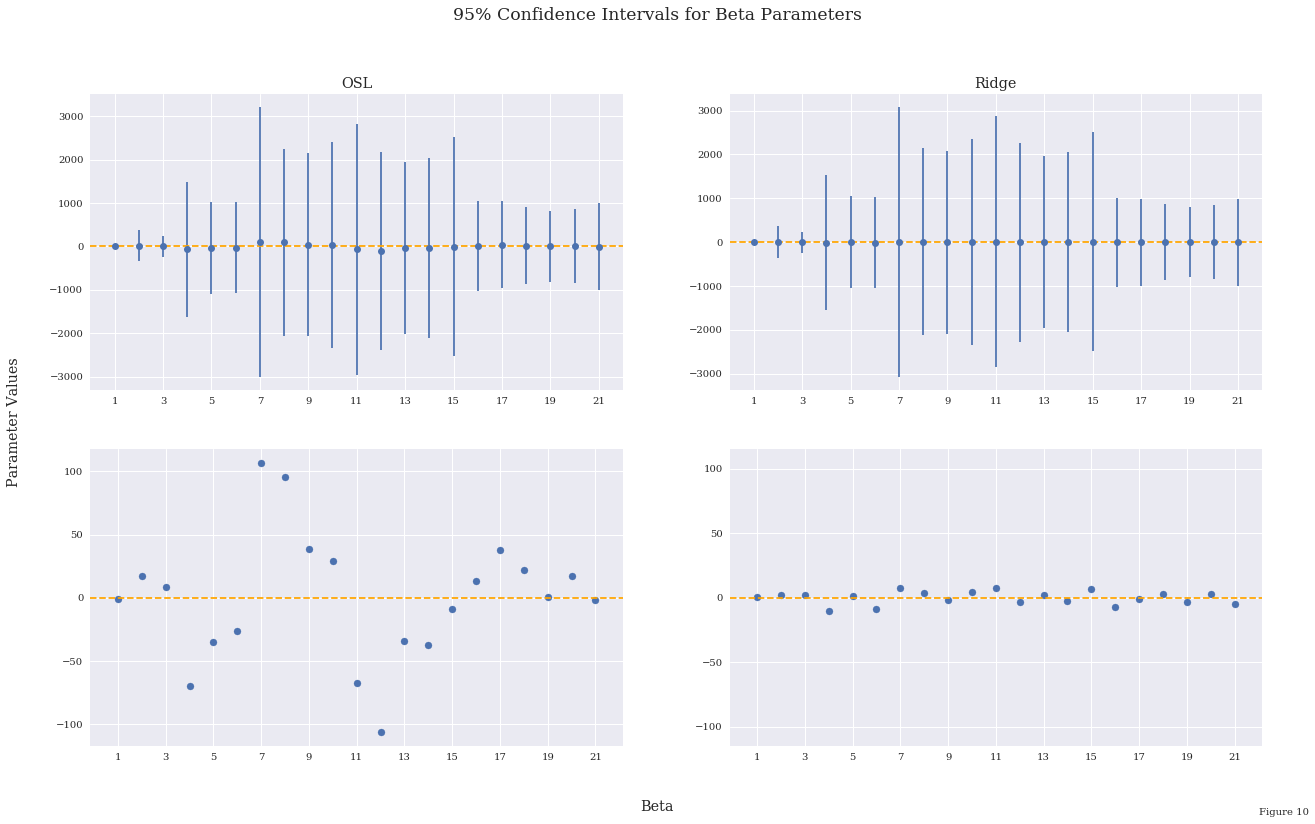

In [20]:
beta5_r = beta5_r.reshape(21)
se_r = sefunction(z5_train, X5_train, beta5_r)
interval_r = conffunction(beta5_r, se_r)
IN = np.vstack((interval_r[:, 0], beta5_r, interval_r[:, 1], se_r))
IN = pd.DataFrame(IN)              
IN.index = ["Lower", "Beta", "Upper", "SD"] 
IN.columns = np.arange(1, 22)
display(IN)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(21, 12))
fig.suptitle('95% Confidence Intervals for Beta Parameters', size = "xx-large")

ax1.set_xticks(np.arange(1, 22, 2))
ax1.axhline(np.mean(beta5), c="orange", linestyle= "--")
ax1.errorbar(x = np.arange(1,22, 1), y = beta5, yerr = (1.96*se), fmt='o')
ax1.set_title("OSL", size = "x-large")

ax2.set_xticks(np.arange(1, 22, 2))
ax2.axhline(np.mean(beta5_r), c="orange", linestyle= "--")
ax2.errorbar(x = np.arange(1,22, 1), y = beta5_r, yerr = (1.96*se_r), fmt='o')
ax2.set_title("Ridge", size = "x-large")

ax3.set_xticks(np.arange(1, 22, 2))
ax3.axhline(np.mean(beta5), c="orange", linestyle= "--")
ax3.scatter(x = np.arange(1, 22, 1), y = beta5)

ax4.set_xticks(np.arange(1, 22, 2))
ax4.set_ylim(-115, 115)
ax4.axhline(np.mean(beta5_r), c="orange", linestyle= "--")
ax4.scatter(x = np.arange(1, 22, 1), y = beta5_r)

fig.text(0.5, 0.05, 'Beta', ha='center', size = "x-large")
fig.text(0.07, 0.5, 'Parameter Values', va='center', rotation='vertical', size = "x-large")
plt.text(22, -170, 'Figure 10', va="bottom", size = "medium")

The parameters' variance didn't decrease, but stayed pretty much the same, meaning that the intervals didn't become more accurate, but the $\beta$ values got very much closer to zero, and we used as a $\lambda$ hyperparameter "just" 0.0001.

We will perform now the same Ridge Regression, but applying the Bootstrap resampling in order to select the best model among the first 10 polynomials.

In [21]:
np.random.seed(18)
n_boostraps = 100
maxdegree = 11
z_test = z_test.reshape(20,1)

error = np.zeros((maxdegree, 1))
bias = np.zeros((maxdegree, 1))
variance = np.zeros((maxdegree, 1))

zpred_r = np.zeros((z_test.shape[0], n_boostraps)) 
    
for degree in range(1,maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), skl.Ridge(alpha = bestlambda_r[degree]))
    
    for i in range(n_boostraps):
        x_, y_ = resample(X_train, z_train)
        zpred_r[:, i] = model.fit(x_, y_).predict(X_test).ravel()
    error[degree] = np.mean(np.mean((z_test - zpred_r)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean((z_test - np.mean(zpred_r, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean(np.var(zpred_r, axis=1, keepdims=True) )

B["Error - Ridge"] = error[1:11, :]
B["Bias - Ridge"] = bias[1:11, :]
B["Variance - Ridge"] = variance[1:11, :]   
B = B.round(3)
display(B)

,Error - OLS,Bias - OLS,Variance - OLS,Error - Ridge,Bias - Ridge,Variance - Ridge
1,0.021,0.020,0.001,0.016,0.016,0.001
2,0.019,0.017,0.002,0.021,0.020,0.001
3,0.010,0.009,0.001,0.016,0.015,0.001
4,0.013,0.006,0.007,0.011,0.010,0.001
5,0.025,0.007,0.018,0.008,0.006,0.002
6,0.043,0.004,0.040,0.010,0.004,0.005
7,0.733,0.087,0.646,0.009,0.003,0.006
8,18.649,0.179,18.470,0.014,0.003,0.011
9,35.833,0.203,35.629,0.010,0.004,0.007
10,32.688,0.233,32.455,0.014,0.005,0.009


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


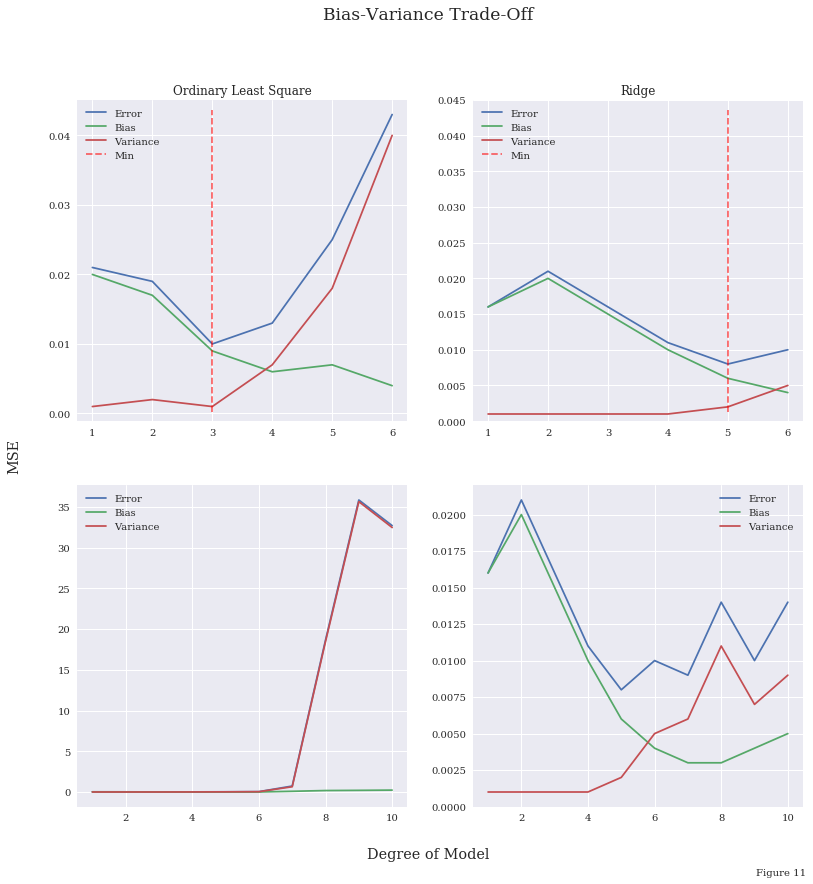

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(13,13))
fig.suptitle('Bias-Variance Trade-Off', size = "xx-large")

ax1.plot(deg[0:6], B.iloc[0:6, 0], label='Error')
ax1.plot(deg[0:6], B.iloc[0:6, 1], label='Bias')
ax1.plot(deg[0:6], B.iloc[0:6, 2], label='Variance')
ax1.axvline(x = B["Error - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax2.plot(deg[0:6], B.iloc[0:6, 3], label='Error')
ax2.plot(deg[0:6], B.iloc[0:6, 4], label='Bias')
ax2.plot(deg[0:6], B.iloc[0:6, 5], label='Variance')
ax2.axvline(x = B["Error - Ridge"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax2.set_ylim(0, 0.045)

ax3.plot(deg, B["Error - OLS"], label='Error')
ax3.plot(deg, B["Bias - OLS"], label='Bias')
ax3.plot(deg, B["Variance - OLS"], label='Variance')

ax4.plot(deg, B["Error - Ridge"], label='Error')
ax4.plot(deg, B["Bias - Ridge"], label='Bias')
ax4.plot(deg, B["Variance - Ridge"], label='Variance')

ax1.set_title("Ordinary Least Square") 
ax2.set_title("Ridge")

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "x-large")
fig.text(0.05, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.85, 0.05, 'Figure 11', va="bottom", size = "medium")

ax1.legend()
ax2.legend(loc="upper left")   
ax3.legend()
ax4.legend()   

It is immediately obvious the difference in $MSE$ values between the two Regression methods: the Ridge method produces an overall lower $MSE$ and the difference between the two methods becomes pretty sizable as the complexity of the model increases. For the tenth degree model we have an error of 32.8 for the OLS Regression and 0.016 for the Ridge Regression. 
We can also see that in the OLS Regression the error and the variance increase way faster than in the Ridge Regression, that is because in the OLS Regression the $\beta$ parameters are not forced to go towards zero, so in complex models we still find many parameters which bring the model to overfit. In the Ridge Regression, on the other hand, many parameters (as we have seen in the Figure 10) are forced to shrink, which means that their contribution to the model is very little and the test data can be predicted more easily no matter which training set we use.

We now perform a Cross-Validation with the same previous purpose. We'll do again a 5-fold Cross-Validation and a 10-fold.

In [23]:
mean5_r = np.zeros(maxdegree)
mean10_r = np.zeros(maxdegree)

kfold5 = KFold(n_splits = 5)
kfold10 = KFold(n_splits = 10)
kfold = [kfold5, kfold10]

for i in (0, 1):
    for degree in range(1, maxdegree):
        polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
        ridge =  Ridge(alpha = bestlambda_r[degree])
        pipeline = Pipeline([("polynomial_features", polynomial_features), ("ridge", ridge)])
        pipeline.fit(X_scaled, z)

        scores = cross_val_score(pipeline, X_scaled, z, scoring="neg_mean_squared_error", cv=kfold[i])
        if i == 0:
            mean5_r[degree] = -scores.mean()
        else: 
            mean10_r[degree] = - scores.mean() 

CV["MSE_5fold - Ridge"] = mean5_r[1:]
CV["MSE_10fold - Ridge"] = mean10_r[1:]
display(CV.round(4))

,MSE_5fold - OLS,MSE_10fold - OLS,MSE_5fold - Ridge,MSE_10fold - Ridge
1,0.0173,0.0179,0.0173,0.0178
2,0.0151,0.0157,0.0151,0.0157
3,0.0078,0.0077,0.0078,0.0077
4,0.0075,0.0072,0.0075,0.0072
5,0.0037,0.0042,0.0036,0.0042
6,0.0063,0.0099,0.0063,0.0099
7,0.0771,0.0323,0.0771,0.0324
8,0.0226,0.0488,0.0216,0.0480
9,3.4412,0.4870,2.9617,0.5983
10,21.9436,2.3383,3.9356,0.1502


The error obtained with the 10-fold Cross-Validation is overall smaller than the one obtained with the 5-fold Cross-Validation, especially from the tenth degree model.

In [24]:
COMP["MSE Bootstrap - Ridge"] = B["Error - Ridge"]
COMP["MSE_5fold - Ridge"] = CV["MSE_5fold - Ridge"]
COMP["MSE_10fold - Ridge"] = CV["MSE_10fold - Ridge"]  
display(COMP.round(4))

,MSE Bootstrap - OLS,MSE_5fold - OLS,MSE_10fold - OLS,MSE Bootstrap - Ridge,MSE_5fold - Ridge,MSE_10fold - Ridge
1,0.021,0.017,0.018,0.016,0.0173,0.0178
2,0.019,0.015,0.016,0.021,0.0151,0.0157
3,0.010,0.008,0.008,0.016,0.0078,0.0077
4,0.013,0.007,0.007,0.011,0.0075,0.0072
5,0.025,0.004,0.004,0.008,0.0036,0.0042
6,0.043,0.006,0.010,0.010,0.0063,0.0099
7,0.733,0.077,0.032,0.009,0.0771,0.0324
8,18.649,0.023,0.049,0.014,0.0216,0.0480
9,35.833,3.441,0.487,0.010,2.9617,0.5983
10,32.688,21.944,2.338,0.014,3.9356,0.1502


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


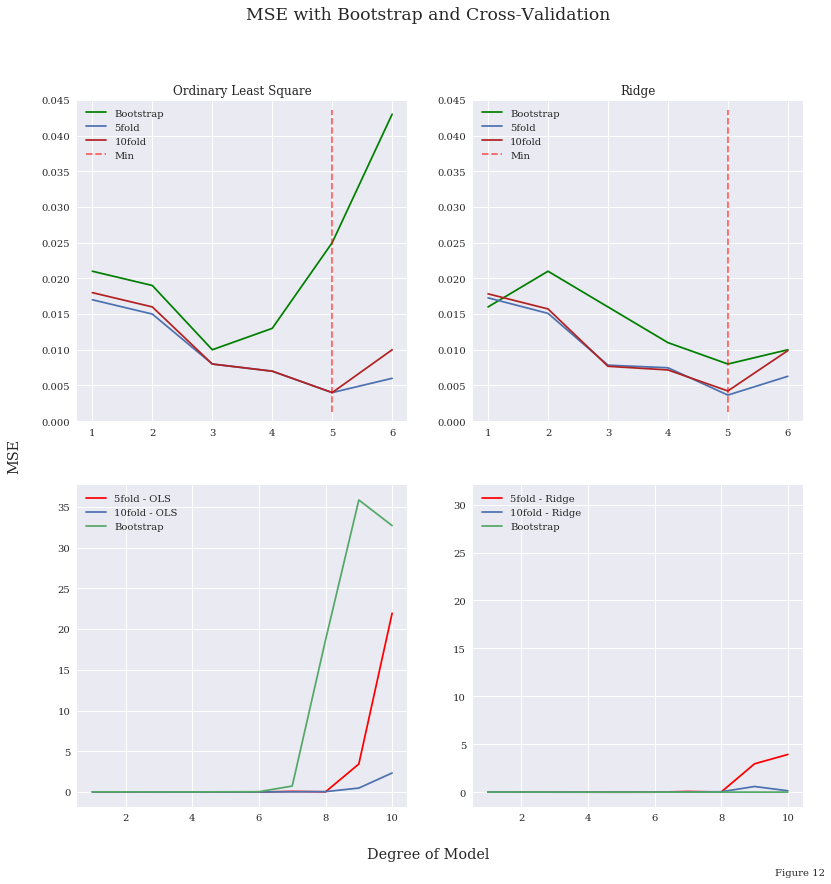

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(13,13))
fig.suptitle('MSE with Bootstrap and Cross-Validation', size = "xx-large")

ax1.plot(deg[0:6], COMP.iloc[0:6, 0], label = "Bootstrap", c = "green")
ax1.plot(deg[0:6], COMP.iloc[0:6, 1], label = "5fold")
ax1.plot(deg[0:6], COMP.iloc[0:6, 2], label = "10fold", c = "firebrick")
ax1.axvline(x = COMP["MSE_10fold - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax1.set_ylim(0, 0.045)

ax2.plot(deg[0:6], COMP.iloc[0:6, 3], label = "Bootstrap", c = "green")
ax2.plot(deg[0:6], COMP.iloc[0:6, 4], label = "5fold")
ax2.plot(deg[0:6], COMP.iloc[0:6, 5], label = "10fold", c = "firebrick")
ax2.axvline(x = COMP["MSE_10fold - Ridge"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax2.set_ylim(0, 0.045)

ax3.plot(deg, CV["MSE_5fold - OLS"], label = "5fold - OLS", c = "red")
ax3.plot(deg, CV["MSE_10fold - OLS"], label = "10fold - OLS")
ax3.plot(deg, B["Error - OLS"], label = "Bootstrap")

ax4.plot(deg, CV["MSE_5fold - Ridge"], label = "5fold - Ridge", c = "red")
ax4.plot(deg, CV["MSE_10fold - Ridge"], label = "10fold - Ridge")
ax4.plot(deg, B["Error - Ridge"], label = "Bootstrap")
ax4.set_ylim(-1.5, 32)

ax1.set_title("Ordinary Least Square") 
ax2.set_title("Ridge")

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "x-large")
fig.text(0.05, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.87, 0.05, 'Figure 12', va="bottom", size = "medium")

ax1.legend(loc= "upper left")
ax2.legend(loc= "upper left")   
ax3.legend(loc= "upper left")
ax4.legend(loc= "upper left")

If we look at the Cross-Validation we notice that for the models with a lower degree order there's no difference between the two Regression methods, whereas the difference is noticeable for higher degree polynomials. The reason is the same as before: the shrinkage towards zero of many of the $\beta$ parameters. If we look at the Bootstrap, on the other hand, we can see that the OLS Regression presents the highest $MSE$, whereas in the Ridge we find lower $MSE$ with the Bootstrap then with the Cross-Validation, especially for higher degree models.

## Exercise 5: Lasso Regression on the Franke Function with Resampling

Also the Lasso Regression adds a regularization parameter $\lambda$ to the Ordinary Least Squares method, but it leads to a different Cost-Function to minimize:

$$\hat{\beta}_{Lasso} = {\underset{\boldsymbol{\beta}}{\operatorname{arg\,min}}}\bigg[\frac{1}{n}\sum_{i=0}^{n-1}{(y_i−\sum _{j=1}^{p}X_{ij}\beta _{j}})^2 + \lambda\sum _{j=1}^{p}|\beta_j|\bigg]$$

Since we have the absolute value of $\beta$, when we have to take the derivative in order to minimize the Cost-Function we have: 

$$\frac{dC(\textbf{X}\beta)}{d\beta} = -2\textbf{X}^T(\textbf{y} -\textbf{X}\beta) + \lambda sgn(\beta) = 0 $$

where $$ sgn(\beta) =
\begin{cases}
 1  \quad  \beta \ge 0 \\
 0  \quad  \beta = 0 \\
-1 \quad  \beta \le 0
\end{cases}$$

This equation does not lead to a nice analytical equation as in Ridge or Ordinary Least Squares.  

The difference with the Ridge Regression is the with Lasso some $\beta$ coefficients can be zero, and not just shrink towards zero.  

Also when we use the Lasso Regression our design matrix $\textbf{X}$ doesn't have to have full rank, since we can see that we're adding $\lambda$ to its diagonal before inverting it.

Let's now use the Cross-Validation to select the best $\lambda$ for the Lasso Regression computing a 5-fold Cross-Validation and calculating the $MSE$ for each of the $\lambda \in [10^{-4}, 10^4]$.

In [26]:
np.random.seed(1818)
n = 100
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y) + 0.001*np.random.standard_normal(n)
X = np.stack((x, y), axis = -1)

nlambdas = 100
lambdas = np.logspace(-4, 4, nlambdas)

maxdegree = 11
k = 5
kfold_l = KFold(n_splits = k)
estimated_mse_l = np.zeros((maxdegree, nlambdas))
bestlambda_l = np.zeros(maxdegree)
mse_l = np.zeros(maxdegree)

for degree in range(1, maxdegree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xft = poly.fit_transform(X)
    scaler = StandardScaler()
    scaler.fit(Xft)
    Xft_scaled = scaler.transform(Xft)
    i = 0
    minim = float("inf")
    for lmb in lambdas:
        lasso = Lasso(lmb, max_iter = 2000, tol = 0.04)
        estimated_mse_folds = cross_val_score(lasso, Xft_scaled, z, scoring='neg_mean_squared_error', cv=kfold_l)
        estimated_mse_l[degree, i] = np.mean(- estimated_mse_folds)
        if estimated_mse_l[degree, i] < minim:
            bestlambda_l[degree] = lmb
            minim = estimated_mse_l[degree, i]
            mse_l[degree] = estimated_mse_l[degree, i]
        i += 1
    
LL = np.stack((bestlambda_l, mse_l), axis = -1)
LL = pd.DataFrame(LL)
LL = LL.drop(0)
LL = LL.round(4) 
LL.columns = ["Best Lambda", "Min MSE"]
LL.index = np.arange(1, 11)   
display(LL)

,Best Lambda,Min MSE
1,0.0009,0.0173
2,0.0009,0.0149
3,0.0001,0.0084
4,0.0001,0.0081
5,0.0001,0.0082
6,0.0001,0.0085
7,0.0001,0.0086
8,0.0001,0.0086
9,0.0001,0.0084
10,0.0001,0.0082


Text(0.5, 0.98, 'Best Lambda for Each Model')

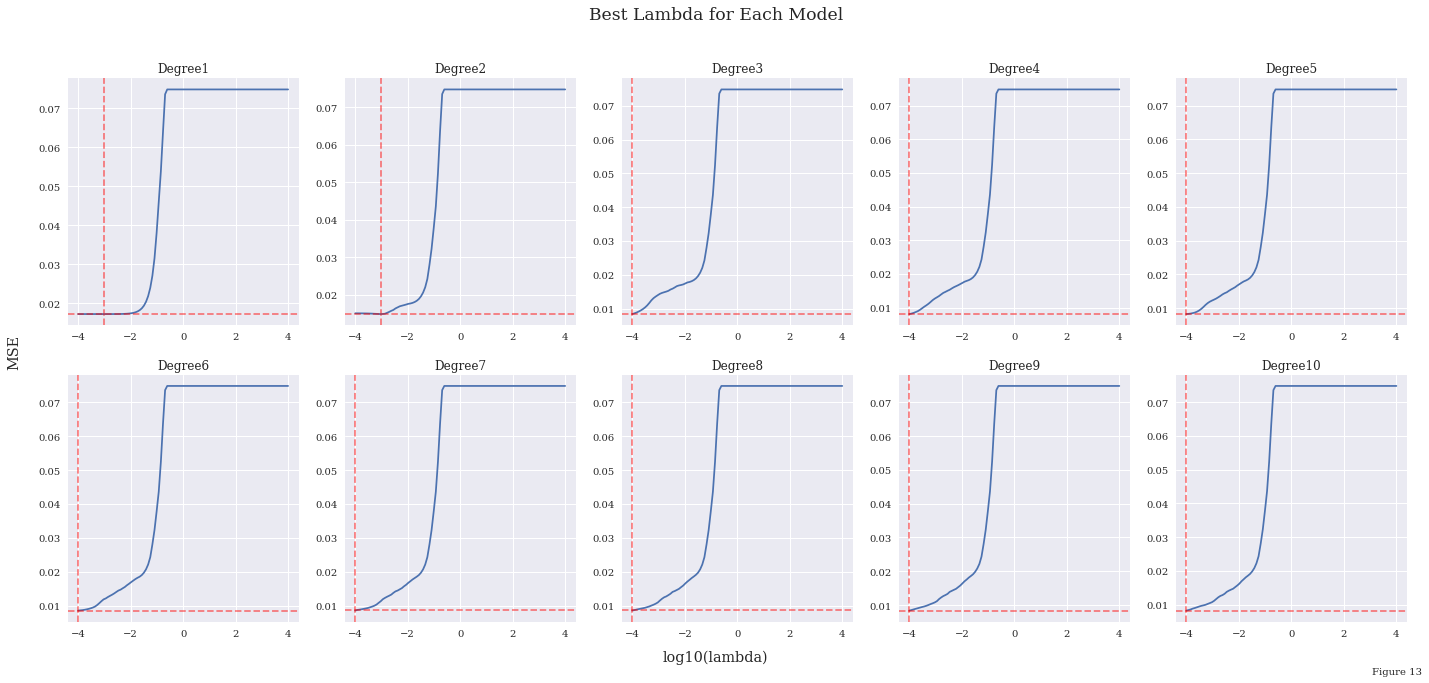

In [27]:
fig, ax = plt.subplots(2,5, figsize=(24, 10))
ax = ax.ravel()
for i in range(1, 11):
    ax[i - 1].plot(np.log10(lambdas), estimated_mse_l[i, :])
    ax[i - 1].axvline(x=(np.log10(bestlambda_l[i])), c= "red", linestyle = "--", alpha = 0.5)
    ax[i - 1].axhline(y = LL.iloc[i-1, 1], c= "red", linestyle = "--", alpha = 0.5)
    ax[i - 1].set_title("Degree" + str(deg[i-1]))
fig.text(0.88, 0.05, 'Figure 13', va="bottom", size = "medium")
fig.text(0.09, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.5, 0.07,'log10(lambda)', ha="center", size = "x-large")
fig.suptitle("Best Lambda for Each Model", size = "xx-large")

Here we have 10 graphics showing the $MSE$ for all of the $\lambda$ values we took into account. We can see that, as the value of $\lambda$ increases, the $MSE$ increases as well, but at a certain point we reach a plateau: this means that all of the parameters $\beta$ are set to zero and therefor the $MSE$ can't increase any further.
We know that for higher values of $\lambda$ the paramaters $\beta$ go through a heavier shrinkage until they become zero, so we have models that don't really fit to the data, since a lot of the parameters are not even taken into account. 

Now let's perform a Lasso Regression on the fifth degree polynomial we already used for the OLS and Ridge Regression and to do so we use the best $\lambda$ we found for this model with the Cross-Validation: 0.0001

,R2 - OLS,MSE - OLS,R2-Ridge,MSE-Ridge,R2-Lasso,MSE-Lasso
Training,0.981733,0.001369,0.957118,0.003213,-0.882447,0.141045
Test,0.973623,0.001609,0.954956,0.002748,-0.949720,0.118931


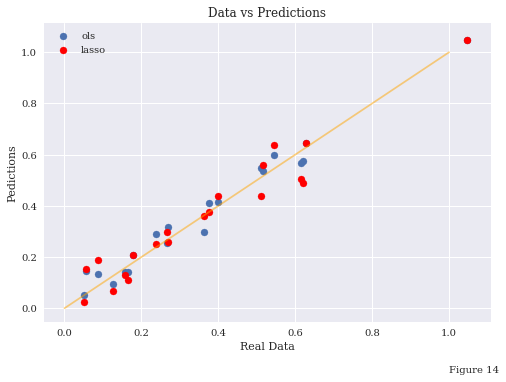

In [28]:
lambda_l = 0.0001
lasso = Lasso(lambda_l, max_iter = 2000, tol = 0.0006)
lasso.fit(X5_train, z5_train)
ztilde5_l = lasso.predict(X5_train)
zpred5_l = lasso.predict(X5_test)
beta5_l = lasso.coef_

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model)** 2) / np.sum((y_data - np.mean(y_data))** 2)


G["R2-Lasso"] = [1 - np.mean((z5_train - ztilde5_l)**2) / np.mean((z5_train - np.mean(ztilde5_l))**2),
                 1 - np.mean((z5_test - zpred5_l)**2) / np.mean((z5_test - np.mean(zpred5_l))**2)]
G["MSE-Lasso"] = [MSE(z5_train, ztilde5_l), MSE(z5_test, zpred5_l)]
display(G.iloc[:, [0,1,4,5,6,7]])

plt.scatter(z5_test, zpred5, label= "ols")
plt.scatter(z5_test, zpred5_l, label="lasso", c="red")
plt.plot([0, 1], c = "orange", alpha = 0.5)
plt.xlabel("Real Data")
plt.ylabel("Pedictions")
plt.title("Data vs Predictions")
plt.text(1, -0.26, 'Figure 14', va="bottom", size = "medium")
plt.legend()

If we compare the fit of the model obtained with Lasso to the one obtained with OLS, we can see that we get a completely different output: with Lasso the $R^2$ is negative and the test $MSE$ is almost 100 times bigger.

Let's compute the $95\%$ confidence intervals of the $\beta$ parameters and see how much they shrunk and how many of them went to zero compared to the ones we obtained with the OLS regression.

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Lower,-112.134486,-1210.359086,-805.285925,-5200.352834,-3514.906673,-3488.551505,-10342.384885,-7173.886019,-7007.727154,-7895.360141,...,-7624.605343,-6633.571189,-6888.575440,-8405.749920,-3433.811884,-3346.915369,-2945.212472,-2697.329139,-2829.047890,0.000000
Beta,0.000000,-1.446185,0.000000,-0.000000,1.582128,-2.623242,0.890988,0.038324,-0.174947,0.000000,...,0.021098,-0.000000,-0.582982,1.469473,-0.625950,0.000000,-0.000000,-0.000000,-0.000000,0.344057
Upper,112.134486,1207.466716,805.285925,5200.352834,3518.070929,3483.305022,10344.166862,7173.962667,7007.377261,7895.360141,...,7624.647538,6633.571189,6887.409477,8408.688866,3432.559984,3346.915369,2945.212472,2697.329139,2829.047890,0.000000
Se,57.211473,616.792296,410.860166,2653.241242,1794.126939,1778.534828,5277.181568,3660.165481,3575.281739,4028.244970,...,3890.115531,3384.475096,3514.281867,4289.397650,1751.625476,1707.609882,1502.659425,1376.188336,1443.391781,1704.004307


Text(22, -170, 'Figure 15')

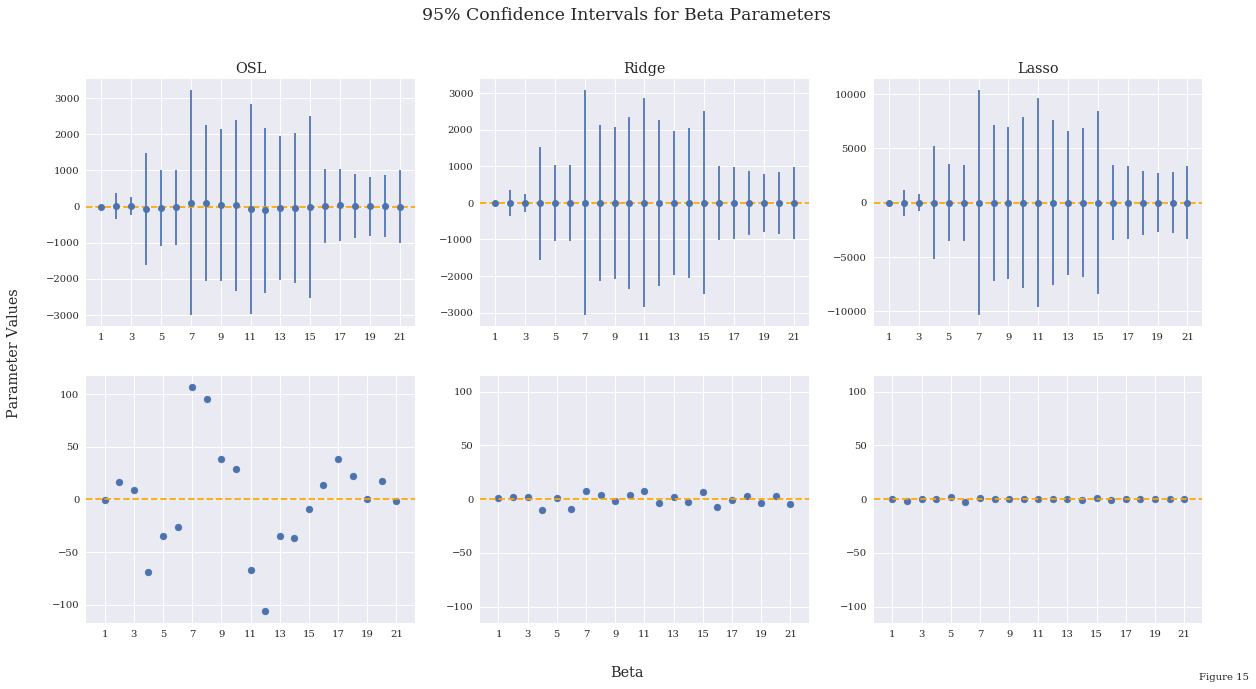

In [29]:
se_l = sefunction(z5_train, X5_train, beta5_l)
interval_l = conffunction(beta5_l, se_l)
IN = np.vstack((interval_l[:, 0], beta5_l, interval_l[:, 1], se_l))
IN = pd.DataFrame(IN)              
IN.index = ["Lower", "Beta", "Upper", "Se"] 
IN.columns = np.arange(0, 21)
display(IN)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20, 10))
fig.suptitle("95% Confidence Intervals for Beta Parameters", size = "xx-large")

ax1.set_xticks(np.arange(1, 22, 2))
ax1.axhline(np.mean(beta5), c="orange", linestyle= "--")
ax1.errorbar(x = np.arange(1,22, 1), y = beta5, yerr = (1.96*se), fmt='o')
ax1.set_title("OSL", size = "x-large")

ax2.set_xticks(np.arange(1, 22, 2))
ax2.axhline(np.mean(beta5_r), c="orange", linestyle= "--")
ax2.errorbar(x = np.arange(1,22, 1), y = beta5_r, yerr = (1.96*se_r), fmt='o')
ax2.set_title("Ridge", size = "x-large")

ax3.set_xticks(np.arange(1, 22, 2))
ax3.axhline(np.mean(beta5_l), c="orange", linestyle= "--")
ax3.errorbar(x = np.arange(1,22, 1), y = beta5_l, yerr = (1.96*se_l), fmt='o')
ax3.set_title("Lasso", size = "x-large")

ax4.set_xticks(np.arange(1, 22, 2))
ax4.axhline(np.mean(beta5), c="orange", linestyle= "--")
ax4.scatter(x = np.arange(1, 22, 1), y = beta5)

ax5.set_xticks(np.arange(1, 22, 2))
ax5.set_ylim(-115, 115)
ax5.axhline(np.mean(beta5_r), c="orange", linestyle= "--")
ax5.scatter(x = np.arange(1, 22, 1), y = beta5_r)

ax6.set_xticks(np.arange(1, 22, 2))
ax6.set_ylim(-115, 115)
ax6.axhline(np.mean(beta5_l), c="orange", linestyle= "--")
ax6.scatter(x = np.arange(1, 22, 1), y = beta5_l)

fig.text(0.5, 0.05, 'Beta', ha='center', size = "x-large")
fig.text(0.07, 0.5, 'Parameter Values', va='center', rotation='vertical', size = "x-large")
plt.text(22, -170, 'Figure 15', va="bottom", size = "medium")

The parameters' variance didn't decrease, on the contrary it increases, meaning that the intervals became even less accurate. The $\beta$ values, however, got closer to zero also compared to the Ridge parameters. Let's see how many of them are actually equal to zero.

In [30]:
BETA = np.vstack((beta5, beta5_r, beta5_l))
BETA = pd.DataFrame(BETA)
BETA.index = ["OLS", "Ridge", "Lasso"]
display(BETA.round(3))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
OLS,-0.525,16.940,8.791,-69.299,-35.177,-26.339,106.705,95.646,38.660,28.861,...,-106.307,-34.360,-37.087,-8.715,13.301,38.222,22.031,0.701,17.423,-1.856
Ridge,0.857,1.773,2.003,-10.175,1.217,-8.691,7.180,3.975,-1.611,4.185,...,-3.638,2.261,-2.448,6.497,-7.017,-1.118,2.869,-3.641,2.616,-4.615
Lasso,0.000,-1.446,0.000,-0.000,1.582,-2.623,0.891,0.038,-0.175,0.000,...,0.021,-0.000,-0.583,1.469,-0.626,0.000,-0.000,-0.000,-0.000,0.344


We can see that most of the parameters have incredibly shrank from the OLS to the Ridge Regression and a lot of them shank even more in the Lasso Regression, with 11 coefficients out of 21 equal to zero. If our $\lambda$ had been larger, more and more coefficients would have been equal to zero.

Let's plot the behaviour of the $\beta$ parameters as $\lambda$ changes.

Text(0.87, 0.001, 'Figure 16')

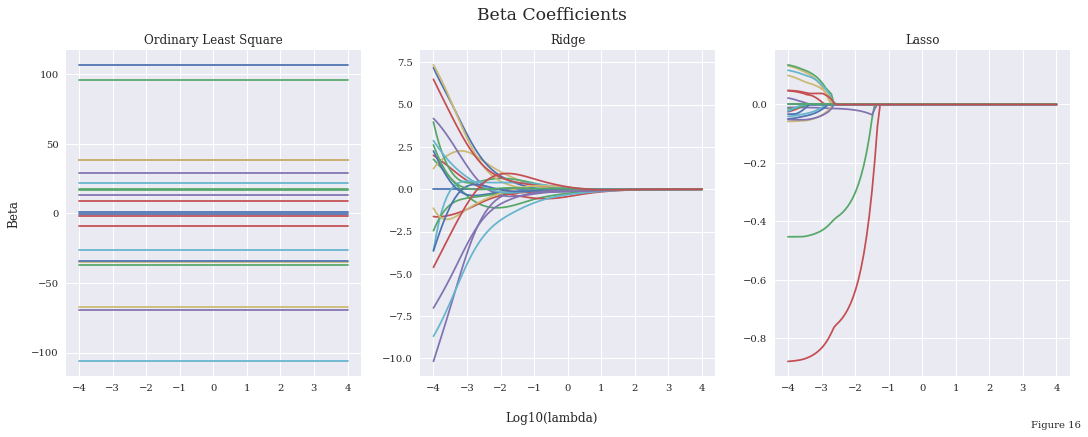

In [31]:
nlambdas = 100
lambdas = np.logspace(-4, 4, nlambdas)
coefsOLS = []
coefsRidge = []
coefsLasso = []

for i in range(100):
    lin = LinearRegression(fit_intercept=False)
    lin.fit(X5_train, z5_train)
    coefsOLS.append(lin.coef_[0])
    
    ridge = Ridge(alpha = lambdas[i])
    ridge.fit(X5_train, z5_train)
    coefsRidge.append(ridge.coef_[0])
    
    lasso = Lasso(alpha = lambdas[i], max_iter = 6000, tol = 0.5)
    lasso.fit(X5_train, z5_train)
    coefsLasso.append(lasso.coef_)
    
    
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
fig.suptitle('Beta Coefficients', size = "xx-large")

ax1.plot(np.log10(lambdas), coefsOLS)
ax1.set_title('Ordinary Least Square')
    
ax2.plot(np.log10(lambdas), coefsRidge)
ax2.set_title('Ridge')

ax3.plot(np.log10(lambdas), coefsLasso)
ax3.set_title('Lasso')

fig.text(0.5, 0.02, 'Log10(lambda)', ha='center', size = "large")
fig.text(0.08, 0.5, 'Beta', va='center', rotation='vertical', size = "large")
fig.text(0.87, 0.001, 'Figure 16', va="bottom", size = "medium")

We can see that of course the coefficients in the Oridnary Least Squares never change. The Ridge and Lasso parameters, on the other hand, shrink towards zero, but we can see how the Ridge $\beta$ continuously shrink, but never really hit zero, whereas the Lasso $\beta$ at a certain point reach zero. We can see that before $\lambda = 0.1$ already all of the parameters are equal to zero.


Now we will perform the same Lasso Regression, but applying the Bootstrap resampling in order to select the best model among the first 10 polynomials.

In [32]:
np.random.seed(18)
n_boostraps = 100
maxdegree = 11
z_test = z_test.reshape(20,1)

error_l = np.zeros((maxdegree, 1))
bias_l = np.zeros((maxdegree, 1))
variance_l = np.zeros((maxdegree, 1))

zpred_l = np.zeros((z_test.shape[0], n_boostraps)) 
    
for degree in range(1,maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), skl.Lasso(bestlambda_l[degree], max_iter = 2000, tol = 0.04))
    
    for i in range(n_boostraps):
        x_, y_ = resample(X_train, z_train)
        zpred_l[:, i] = model.fit(x_, y_).predict(X_test).ravel()
    error_l[degree] = np.mean(np.mean((z_test - zpred_l)**2, axis=1, keepdims=True) )
    bias_l[degree] = np.mean((z_test - np.mean(zpred_l, axis=1, keepdims=True))**2 )
    variance_l[degree] = np.mean(np.var(zpred_l, axis=1, keepdims=True) )

B["Error - Lasso"] = error_l[1:11, :]
B["Bias - Lasso"] = bias_l[1:11, :]
B["Variance - Lasso"] = variance_l[1:11, :]   
B = B.round(4)
display(B)

,Error - OLS,Bias - OLS,Variance - OLS,Error - Ridge,Bias - Ridge,Variance - Ridge,Error - Lasso,Bias - Lasso,Variance - Lasso
1,0.021,0.020,0.001,0.016,0.016,0.001,0.0198,0.0191,0.0007
2,0.019,0.017,0.002,0.021,0.020,0.001,0.0198,0.0187,0.0011
3,0.010,0.009,0.001,0.016,0.015,0.001,0.0166,0.0152,0.0014
4,0.013,0.006,0.007,0.011,0.010,0.001,0.0174,0.0164,0.0010
5,0.025,0.007,0.018,0.008,0.006,0.002,0.0171,0.0161,0.0010
6,0.043,0.004,0.040,0.010,0.004,0.005,0.0173,0.0159,0.0013
7,0.733,0.087,0.646,0.009,0.003,0.006,0.0167,0.0157,0.0011
8,18.649,0.179,18.470,0.014,0.003,0.011,0.0176,0.0162,0.0014
9,35.833,0.203,35.629,0.010,0.004,0.007,0.0174,0.0163,0.0011
10,32.688,0.233,32.455,0.014,0.005,0.009,0.0172,0.0159,0.0013


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


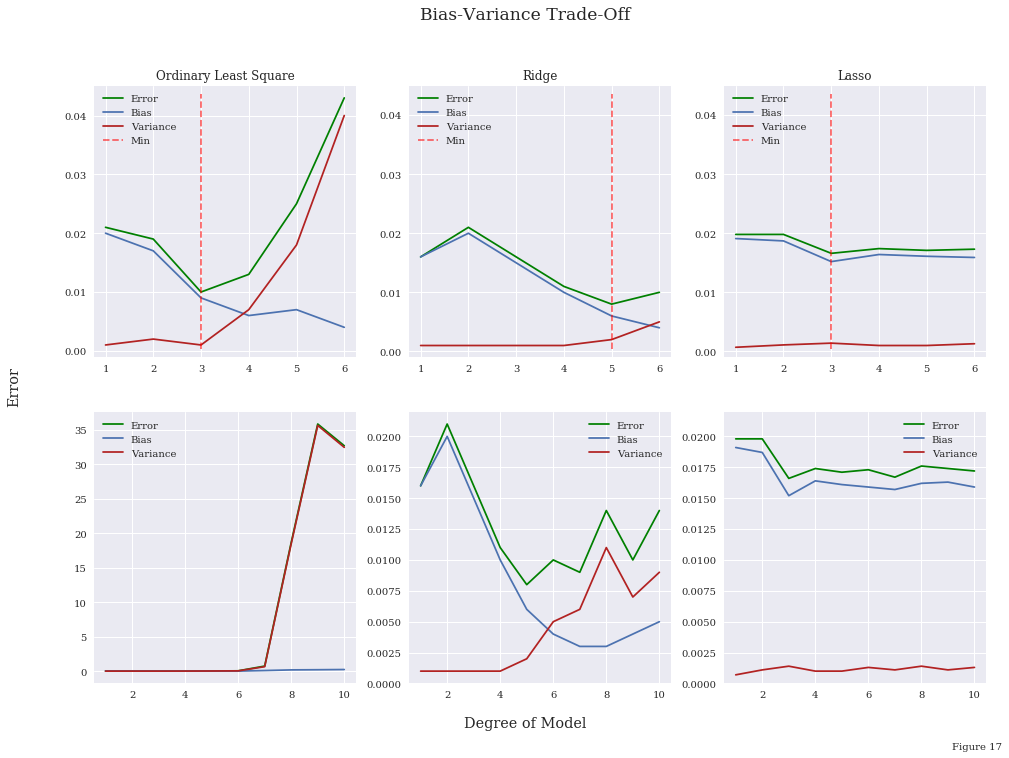

In [33]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,11))
fig.suptitle('Bias-Variance Trade-Off', size = "xx-large")

ax1.plot(deg[0:6], B.iloc[0:6, 0], label='Error', c = "green")
ax1.plot(deg[0:6], B.iloc[0:6, 1], label='Bias')
ax1.plot(deg[0:6], B.iloc[0:6, 2], label='Variance', c = "firebrick")
ax1.axvline(x = B["Error - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax2.plot(deg[0:6], B.iloc[0:6, 3], label='Error', c = "green")
ax2.plot(deg[0:6], B.iloc[0:6, 4], label='Bias')
ax2.plot(deg[0:6], B.iloc[0:6, 5], label='Variance', c = "firebrick")
ax2.axvline(x = B["Error - Ridge"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax2.set_ylim(-0.001, 0.045)

ax3.plot(deg[0:6], B.iloc[0:6, 6], label='Error', c = "green")
ax3.plot(deg[0:6], B.iloc[0:6, 7], label='Bias')
ax3.plot(deg[0:6], B.iloc[0:6, 8], label='Variance', c = "firebrick")
ax3.axvline(x = B["Error - Lasso"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax3.set_ylim(-0.001, 0.045)

ax4.plot(deg, B["Error - OLS"], label='Error', c = "green")
ax4.plot(deg, B["Bias - OLS"], label='Bias')
ax4.plot(deg, B["Variance - OLS"], label='Variance', c = "firebrick")

ax5.plot(deg, B["Error - Ridge"], label='Error', c = "green")
ax5.plot(deg, B["Bias - Ridge"], label='Bias')
ax5.plot(deg, B["Variance - Ridge"], label='Variance', c = "firebrick")

ax6.plot(deg, B["Error - Lasso"], label='Error', c = "green")
ax6.plot(deg, B["Bias - Lasso"], label='Bias')
ax6.plot(deg, B["Variance - Lasso"], label='Variance', c = "firebrick")
ax6.set_ylim(0, 0.022)

ax1.set_title("Ordinary Least Square") 
ax2.set_title("Ridge")
ax3.set_title("Lasso")

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "x-large")
fig.text(0.05, 0.5, 'Error', va='center', rotation='vertical', size = "x-large")
fig.text(0.87, 0.04, 'Figure 17', va="bottom", size = "medium")

ax1.legend()
ax2.legend(loc="upper left")   
ax3.legend(loc="upper left")
ax4.legend()   
ax5.legend()
ax6.legend()

It is immediately obvious the difference in $MSE$ values between the three Regression methods, especially between the OSL and the other two. The Ridge and Lasso methods produce an overall lower $MSE$, with the Ridge Regression as the best. The difference between the three methods becomes pretty sizable as the complexity of the model increases. For the tenth degree model we have an error of 32.688 for the OLS Regression, 0.014 for the Ridge Regression and 0.017 for the Lasso Regression. 
We can also see that in the OLS Regression the error and the variance increase way faster than in the Ridge and Lasso, that is because in the OLS Regression the $\beta$ parameters are not forced to go towards zero, so in complex models we still find many parameters which bring the model to overfit. In the Ridge and Lasso Regression, on the other hand, many parameters (as we have seen in the Figure 15) are forced to shrink (and go to zero in the Lasso case), which means that their contribution to the model is very little (or none) and the test data can be predicted more easily no matter which training set we use.

We now perform a Cross-Validation with the same previous purpose. We'll do again a 5-fold Cross-Validation and a 10-fold.

In [35]:
mean5_l = np.zeros(maxdegree)
mean10_l = np.zeros(maxdegree)

kfold5 = KFold(n_splits = 5)

for degree in range(1, maxdegree):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    lasso =  skl.Lasso(bestlambda_l[degree], max_iter = 2000, tol = 0.006)
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("lasso", lasso)])
    pipeline.fit(X_scaled, z)

    scores = cross_val_score(pipeline, X_scaled, z, scoring="neg_mean_squared_error", cv=kfold5)
    mean5_l[degree] = -scores.mean()
    

kfold10 = KFold(n_splits = 10)

for degree in range(1, maxdegree):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    lasso =  skl.Lasso(bestlambda_l[degree], max_iter = 2000, tol = 0.006)
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("lasso", lasso)])
    pipeline.fit(X_scaled, z)

    scores = cross_val_score(pipeline, X_scaled, z, scoring="neg_mean_squared_error", cv=kfold10)
    mean10_l[degree] = -scores.mean() 
    
CV["MSE_5fold - Lasso"] = mean5_l[1:]
CV["MSE_10fold - Lasso"] = mean10_l[1:]

COMP["MSE Bootstrap - Lasso"] = B["Error - Lasso"]
COMP["MSE_5fold - Lasso"] = CV["MSE_5fold - Lasso"]
COMP["MSE_10fold - Lasso"] = CV["MSE_10fold - Lasso"]  
display(COMP.round(3))

,MSE Bootstrap - OLS,MSE_5fold - OLS,MSE_10fold - OLS,MSE Bootstrap - Ridge,MSE_5fold - Ridge,MSE_10fold - Ridge,MSE Bootstrap - Lasso,MSE_5fold - Lasso,MSE_10fold - Lasso
1,0.021,0.017,0.018,0.016,0.017,0.018,0.020,0.017,0.018
2,0.019,0.015,0.016,0.021,0.015,0.016,0.020,0.015,0.016
3,0.010,0.008,0.008,0.016,0.008,0.008,0.017,0.008,0.008
4,0.013,0.007,0.007,0.011,0.007,0.007,0.017,0.007,0.007
5,0.025,0.004,0.004,0.008,0.004,0.004,0.017,0.003,0.003
6,0.043,0.006,0.010,0.010,0.006,0.010,0.017,0.003,0.002
7,0.733,0.077,0.032,0.009,0.077,0.032,0.017,0.003,0.003
8,18.649,0.023,0.049,0.014,0.022,0.048,0.018,0.004,0.007
9,35.833,3.441,0.487,0.010,2.962,0.598,0.017,0.004,0.006
10,32.688,21.944,2.338,0.014,3.936,0.150,0.017,0.006,0.008


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


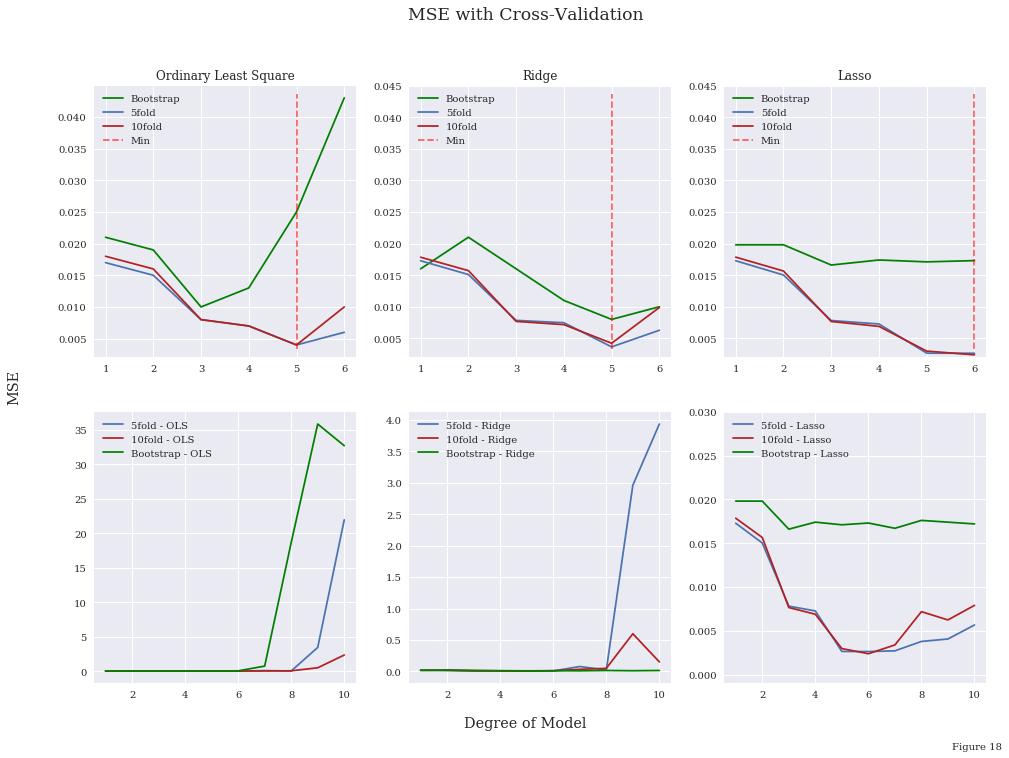

In [36]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,11))
fig.suptitle('MSE with Cross-Validation', size = "xx-large")

ax1.plot(deg[0:6], COMP.iloc[0:6, 0], label = "Bootstrap", c = "green")
ax1.plot(deg[0:6], COMP.iloc[0:6, 1], label = "5fold")
ax1.plot(deg[0:6], COMP.iloc[0:6, 2], label = "10fold", c = "firebrick")
ax1.axvline(x = COMP["MSE_10fold - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax2.plot(deg[0:6], COMP.iloc[0:6, 3], label = "Bootstrap", c = "green")
ax2.plot(deg[0:6], COMP.iloc[0:6, 4], label = "5fold")
ax2.plot(deg[0:6], COMP.iloc[0:6, 5], label = "10fold", c = "firebrick")
ax2.axvline(x = COMP["MSE_10fold - Ridge"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax2.set_ylim(0.002, 0.045)

ax3.plot(deg[0:6], COMP.iloc[0:6, 6], label = "Bootstrap", c = "green")
ax3.plot(deg[0:6], COMP.iloc[0:6, 7], label = "5fold")
ax3.plot(deg[0:6], COMP.iloc[0:6, 8], label = "10fold", c = "firebrick")
ax3.axvline(x = COMP["MSE_10fold - Lasso"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax3.set_ylim(0.002, 0.045)

ax4.plot(deg, CV["MSE_5fold - OLS"], label = "5fold - OLS")
ax4.plot(deg, CV["MSE_10fold - OLS"], label = "10fold - OLS", c = "firebrick")
ax4.plot(deg, B["Error - OLS"], label = "Bootstrap - OLS", c = "green")

ax5.plot(deg, CV["MSE_5fold - Ridge"], label = "5fold - Ridge")
ax5.plot(deg, CV["MSE_10fold - Ridge"], label = "10fold - Ridge", c = "firebrick")
ax5.plot(deg, B["Error - Ridge"], label='Bootstrap - Ridge', c = "green")

ax6.plot(deg, CV["MSE_5fold - Lasso"], label = "5fold - Lasso")
ax6.plot(deg, CV["MSE_10fold - Lasso"], label = "10fold - Lasso", c = "firebrick")
ax6.plot(deg, B["Error - Lasso"], label='Bootstrap - Lasso', c = "green")
ax6.set_ylim(-0.001, 0.03)

ax1.set_title("Ordinary Least Square") 
ax2.set_title("Ridge")
ax3.set_title("Lasso")

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "x-large")
fig.text(0.05, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.87, 0.04, 'Figure 18', va="bottom", size = "medium")

ax1.legend()
ax2.legend(loc="upper left")   
ax3.legend(loc="upper left")
ax4.legend()   
ax5.legend(loc="upper left")
ax6.legend(loc="upper left")

If we look at the results from the OLS we can see that, as already mentioned, the error is higher comprared to the other two regression methods. If we focus on the Ridge and Lasso, we see that the Bootstrap $MSE$ is always lower (as we can see more clearly in Figure 17), but $MSE$ we get from the Cross-Validation is very similar models with a lower degree order, but it becomes very very different for higher degree polynomials, especially for the 5-fold: there's a $MSE$ value of 3.9 for the Ridge Regression and of 0.006 for the Lasso. The reason is the same as before: the shrinkage to zero of many of the $\beta$ parameters. However this effect is not as emphasized in the other two resampling methods.

## EXERCISE 6: Analysis of Real Data

Let's now apply these analysis on some real data. Here I chose a dataset containing data about cars C02 Emissions, and we're going to focus on the response variable **Co2 Emissions** calculated in g/km, which is explained by two features: **Engine Size** calculated in L and **Fuel Consumption** both in the city and on the highway calculated in L/100km. 

### Descriptive Analysis

In [37]:
pollution = pd.read_csv("C:/Users/isabe/OneDrive/Desktop/UNI/OSLO/MACHINE LEARNING/CO2 Emissions_Canada.csv")
pollution = pollution.iloc[:, [3, 9, 11]]
print(pollution.shape)

(7385, 3)


We can see that our datset has 7385 observations and 3 variables.

,Engine Size(L),Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km)
1,2.0,8.5,196
2,2.4,9.6,221
3,1.5,5.9,136
4,3.5,11.1,255
5,3.5,10.6,244


Text(0.89, 0.02, 'Figure 19')

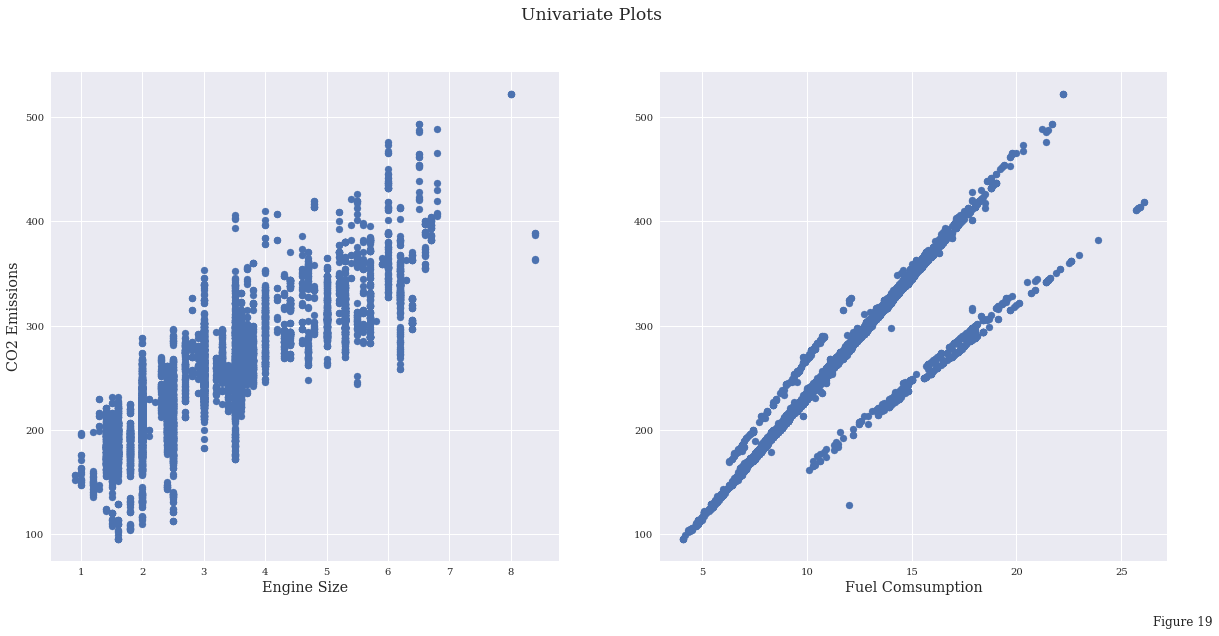

In [38]:
pollution.index = np.arange(1, 7386, 1)
display(pollution.head(5))

xp = pollution.iloc[:, 0]
yp = pollution.iloc[:, 1]
zp = pollution.iloc[:, 2]
zp = zp.to_numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,9))
plt.suptitle("Univariate Plots", size = "xx-large")
ax1.scatter(xp, zp)
ax2.scatter(yp, zp)

ax1.set_xlabel("Engine Size", size = "x-large")
ax1.set_ylabel("CO2 Emissions", size = "x-large")
ax2.set_xlabel("Fuel Comsumption", size = "x-large")

fig.text(0.89, 0.02, 'Figure 19', va="bottom", size = "large")

Here we printed the first 5 rows of the datset to see how the data looks like. It is obvious that the variables have different magnitudes, so we will probably need to scale our data.   
Looking at the univariate plots we can see that there's a linear growing relationship between both of the covariates and the response variable. In the graph with the **Fuel Consumption** we can clearly distinguish three seperate line that grow at a different pace: not all of the cars the consume much fuel reach the same quantity of CO2 Emissions.

Let's look now at the descriptive statistics of the variables.

In [39]:
pollution.describe().round(2)

,Engine Size(L),Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km)
count,7385.00,7385.00,7385.00
mean,3.16,10.98,250.58
std,1.35,2.89,58.51
min,0.90,4.10,96.00
25%,2.00,8.90,208.00
50%,3.00,10.60,246.00
75%,3.70,12.60,288.00
max,8.40,26.10,522.00


We can see that pretty much all of the variables have a mean very similar to the median, which can sometimes be an indication of symmetry, but if we look at the minimum and maximum, we can clearly see that all of the variables have a long heavy right tail. This means that they have a few observations that present very high values compared to the rest of the distribution.  
We also see that the response variable **CO2 Emissions** has the highest standard deviation, which is not surprising since it has the biggest range. This means that the values spread out from the mean 250.58 g/km on average of 58.51 g/km. The two covariates don't present such a high standard deviation, but their range are way smaller.

Text(0.89, 0.08, 'Figure 20')

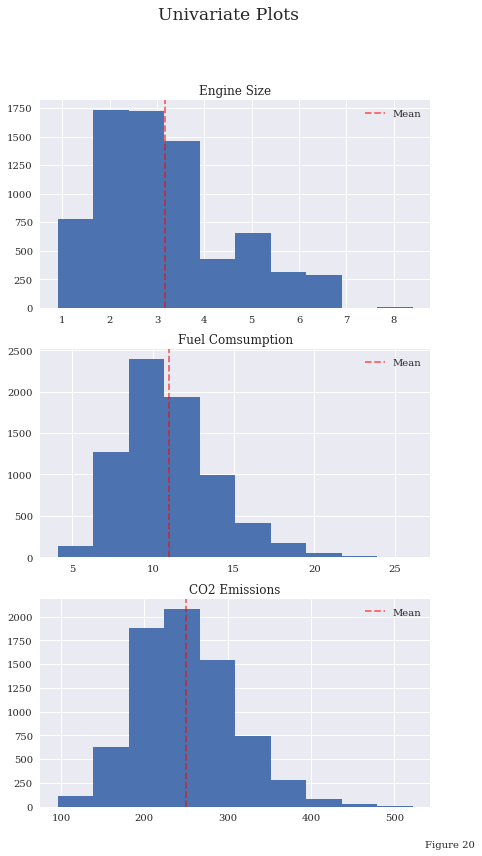

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 13))
plt.suptitle("Univariate Plots", size = "xx-large")
ax1.hist(xp)
ax1.axvline(np.mean(xp), c = "red", linestyle = "--", alpha = 0.6, label = "Mean")
ax2.hist(yp)
ax2.axvline(np.mean(yp), c = "red", linestyle = "--", alpha = 0.6, label = "Mean")
ax3.hist(zp)
ax3.axvline(np.mean(zp), c = "red", linestyle = "--", alpha = 0.6, label = "Mean")

ax1.set_title("Engine Size", size = "large")
ax2.set_title("Fuel Comsumption", size = "large")
ax3.set_title("CO2 Emissions", size = "large")

ax1.legend()
ax2.legend()
ax3.legend()

fig.text(0.89, 0.08, 'Figure 20', va="bottom", size = "medium")

As hypothized, we can confirm that the variables have indeed an asymmetric distribution with a long heavy right tail.

Let's now display the correlation matrix.

In [41]:
cor = pollution.corr()
display(cor.round(3))

,Engine Size(L),Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km)
Engine Size(L),1.000,0.817,0.851
Fuel Consumption Comb (L/100 km),0.817,1.000,0.918
CO2 Emissions(g/km),0.851,0.918,1.000


If we look at the correlation between the response variable and the covariates, we see (as we thought from Figure 19) that they are highly correlated, espcially the Fuel Consumption. We see, moreover, that also the two covariates are very correlated. This could be a problem when calculating the regression model using the OLS because it means we could have a design matrix very close to a singular matrix, but it shouldn't be a problem for the other two Regression methods.

### Ordinary Least Squares Regression
Let's first perform the Regression using the Ordinary Least Squares method without scaling our data.

In [42]:
Xp_unscaled = np.stack((xp, yp), axis = 1)
poly5 = PolynomialFeatures(degree = 5)
X5p_unscaled = poly5.fit_transform(Xp_unscaled)
zp_unscaled = zp

np.random.seed(917)
X5p_train_unscaled, X5p_test_unscaled, z5p_train_unscaled, z5p_test_unscaled = train_test_split(X5p_unscaled, zp_unscaled, 
                                                                                                test_size=0.2)

beta5p_unscaled = np.linalg.inv(X5p_train_unscaled.T.dot(X5p_train_unscaled)).dot(X5p_train_unscaled.T).dot(z5p_train_unscaled)
ztilde5p_unscaled = X5p_train_unscaled @ beta5p_unscaled
zpred5p_unscaled = X5p_test_unscaled @ beta5p_unscaled

Gp = np.hstack((R2(z5p_train_unscaled, ztilde5p_unscaled), R2(z5p_test_unscaled, zpred5p_unscaled)))
Gp = pd.DataFrame(Gp)              
Gp.columns = ["R2 - OLS (Unscaled)"]
Gp.index = ["Training", "Test"]
Gp["MSE - OLS (Unscaled)"] = [MSE(z5p_train_unscaled, ztilde5p_unscaled), MSE(z5p_test_unscaled, zpred5p_unscaled)]

And now let's scale the data and see if it's more convenient. As we said before, it should be, since the variables don't have the same magnitude and we wouldn't want some of our variables to appair to have a bigger influence just because their magnitude is bigger.

In [44]:
scaler = StandardScaler()
scaler.fit(X5p_train_unscaled[:,1:21])
X5p_train = scaler.transform(X5p_train_unscaled[:,1:21])
X5p_test = scaler.transform(X5p_test_unscaled[:,1:21])

z5p_train_unscaled = z5p_train_unscaled.reshape(5908, 1)
z5p_test_unscaled = z5p_test_unscaled.reshape(1477, 1)

scaler.fit(z5p_train_unscaled)
z5p_train = scaler.transform(z5p_train_unscaled)
z5p_test = scaler.transform(z5p_test_unscaled)

beta5p = np.linalg.inv(X5p_train.T.dot(X5p_train)).dot(X5p_train.T).dot(z5p_train)
ztilde5p = X5p_train @ beta5p
zpred5p = X5p_test @ beta5p

,R2 - OLS (Unscaled),MSE - OLS (Unscaled),R2 - OLS,MSE - OLS
Training,0.933620,226.411686,0.933620,0.066380
Test,0.926215,256.247670,0.926215,0.075127


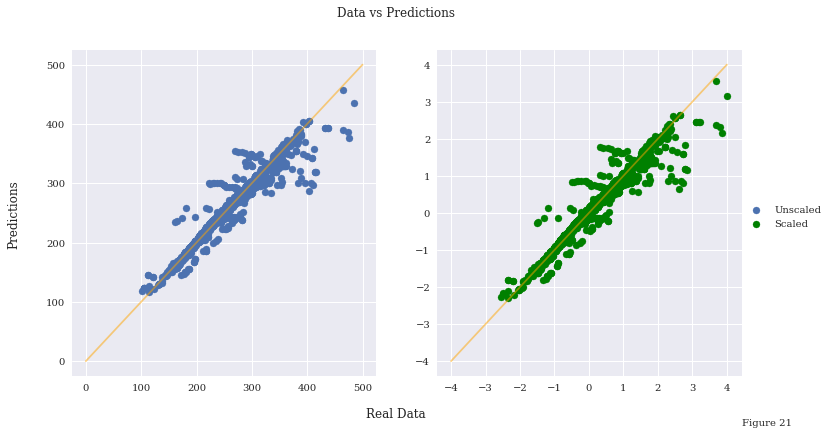

In [45]:
Gp["R2 - OLS"] = [R2(z5p_train, ztilde5p), R2(z5p_test, zpred5p)]
Gp["MSE - OLS"] = [MSE(z5p_train, ztilde5p), MSE(z5p_test, zpred5p)]
display(Gp.round(7))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle("Data vs Predictions")
ax1.scatter(z5p_test_unscaled, zpred5p_unscaled, label = "Unscaled")
ax1.plot([0, 500], [0, 500], c = "orange", alpha = 0.5)
ax2.scatter(z5p_test, zpred5p, c = "green", label = "Scaled")
ax2.plot([-4, 4], [-4, 4], c = "orange", alpha = 0.5)

fig.text(0.5, 0.03, 'Real Data', ha='center', size = "large")
fig.text(0.05, 0.5, 'Predictions', va='center', rotation='vertical', size = "large")
fig.text(0.9, 0.005, 'Figure 21', va="bottom", size = "medium")
fig.legend(loc = "center right")

We see that the model we estimated using unscaled and scaled data presents the same fit, $R^2 = 93\%$, since we scaled both the covariates and the target variable, however, we can also clearly see that the unscaled data present a wider range and their variance is obviously bigger. The real data have a range of $[100, 500]$ whereas the range for the scaled data is $[-2.5, 4]$.

In [46]:
print("Variance Unscaled Data:", np.var(z5p_test_unscaled))
print("Variance Scaled Data:", np.var(z5p_test))

Variance Unscaled Data: 3472.892001894084
Variance Scaled Data: 1.0181888135331227


Also by looking at the $MSE$ we can see that the scaled model produces a smaller error than the unscaled model, 0.075 in the first case versus 256.25 in the second case for the test error, meaning that the predictions are "closer" to the real observations in the first case rather than in the second. 
For all of these reasons we will continue our analysis using scaled data: $X5p$ and $z5p$.

### Confidence Intervals

Now let's calculate the 95% confidence intervals.

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Lower,-602.807041,-521.881508,-2067.304016,-4384.471676,-2496.309612,-4784.512951,-11765.938413,-15192.563003,-7776.858259,-4015.523835,-14508.414884,-27316.808856,-27247.147930,-11693.387016,-3189.428139,-13496.375056,-22601.694750,-24124.538938,-17809.764067,0.000000
Beta,0.930527,-6.344185,25.283396,-41.093278,47.119750,-33.791765,-22.142393,101.700505,-101.143457,-2.896406,110.147202,-134.533303,10.967111,58.804547,35.687706,-147.763530,181.790698,-93.537976,27.437122,-15.669469
Upper,604.668095,509.193138,2117.870808,4302.285121,2590.549112,4716.929421,11721.653627,15395.964014,7574.571344,4009.731023,14728.709288,27047.742249,27269.082151,11810.996110,3260.803551,13200.847995,22965.276145,23937.462985,17864.638310,0.000000
SD,308.029371,263.029246,1067.646639,2216.009387,1297.668042,2423.837340,5991.732663,7803.195667,3916.181021,2047.258892,7458.450044,13868.507935,13907.201551,5996.016104,1645.467268,6810.516085,11624.227269,12260.714776,9100.612851,3423.388625


Text(0.89, 0.03, 'Figure 22')

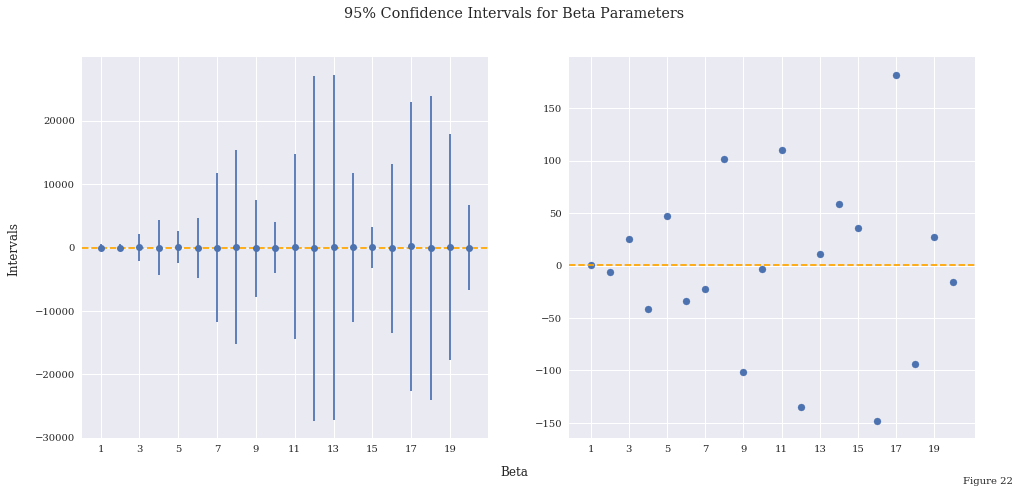

In [47]:
beta5p = beta5p.reshape(20)
se_p = sefunction(z5p_train, X5p_train, beta5p)
interval_p = conffunction(beta5p, se_p)
INp = np.vstack((interval_p[:, 0], beta5p, interval_p[:, 1], se_p))
INp = pd.DataFrame(INp)              
INp.index = ["Lower", "Beta", "Upper", "SD"] 
INp.columns = np.arange(1, 21)
display(INp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('95% Confidence Intervals for Beta Parameters', size = "x-large")

ax1.set_xticks(np.arange(1, 21, 2))
ax1.axhline(np.mean(beta5p), c = "orange", linestyle = "--")
ax1.errorbar(x = np.arange(1, 21, 1), y = beta5p, yerr = (1.96*se_p), fmt='o')

ax2.set_xticks(np.arange(1, 21, 2))
ax2.axhline(np.mean(beta5p), c="orange", linestyle= "--")
ax2.scatter(np.arange(1, 21, 1), beta5p)

fig.text(0.5, 0.05, 'Beta', ha='center', size = "large")
fig.text(0.06, 0.5, 'Intervals', va='center', rotation='vertical', size = "large")
fig.text(0.89, 0.03, 'Figure 22', va="bottom", size = "medium")

We can see that, with an exeption for the first parameters, all of them have very big variance, which results in extremely large intervals, hence very small accuracy when it comes to predict the exact $\beta$ value. Let's look at the eighth parameter: 
$\hat{\beta_8} = - 101.1$ but its $95\%$ confidence interval is: 
$$\hat{\beta_8} \in [- 7776.9; 7574.6]$$
This means that in $95\%$ ofthe cases $\hat{\beta_8}$ will fall into that interval, but as we can see it is pretty big, so this doesn't give us much certainty. 

### Training Error and Test Error with OLS

We now compute and plot the Training Error and the Test Error to make sure not to choose a model that overfits (or that underfits). This usually happens as the complexity of the model increases.

In [48]:
maxdegree = 16
TEp = np.zeros((maxdegree, 2))
deg = np.arange(1, 16)

scaler = StandardScaler()
scaler.fit(Xp_unscaled)
Xp = scaler.transform(Xp_unscaled)

zp_unscaled = zp_unscaled.reshape(7385, 1)
scaler.fit(zp_unscaled)
zp = scaler.transform(zp_unscaled)

np.random.seed(1006)
Xp_train, Xp_test, zp_train, zp_test = train_test_split(Xp, zp, test_size=0.2)

for degree in range(1,maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    lin = model.fit(Xp_train, zp_train)
    ztilde_p = lin.predict(Xp_train)
    zpred_p = lin.predict(Xp_test) 
    TEp[degree, 0] = MSE(zp_train, ztilde_p)
    TEp[degree, 1] = MSE(zp_test, zpred_p)

TEp = pd.DataFrame(TEp)
TEp.columns = ["TrainingError", "TestError"]
TEp = TEp.drop(0)
TEp.indexes = np.arange(0, 16)
TEp = TEp.round(4)                    
display(TEp)

C:\Users\isabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,TrainingError,TestError
1,0.1251,0.1322
2,0.0815,0.0959
3,0.0762,0.0919
4,0.0655,0.0877
5,0.0634,0.0851
6,0.0564,0.0846
7,0.0555,0.0824
8,0.0534,0.0832
9,0.0514,0.0797
10,0.0487,0.0799


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


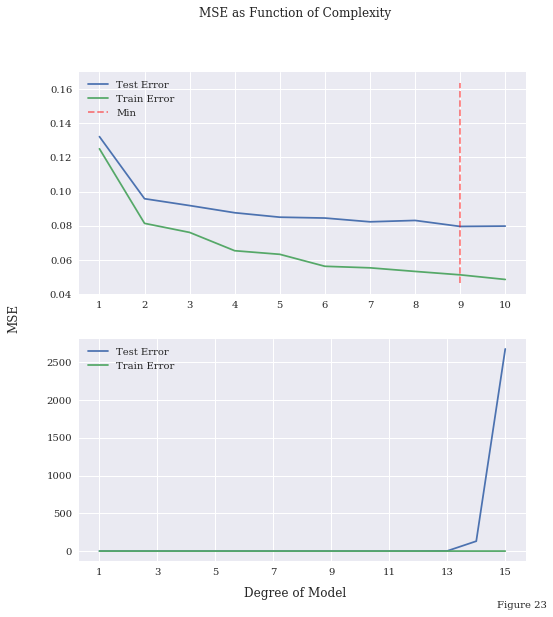

In [49]:
minim = TEp["TestError"].min()
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,9))
fig.suptitle('MSE as Function of Complexity')

ax1.plot(deg[0:10], TEp.iloc[0:10, 1], label='Test Error')
ax1.plot(deg[0:10], TEp.iloc[0:10, 0], label='Train Error')
ax1.set_ylim(0.04, 0.17)
ax1.axvline(x = TEp["TestError"].idxmin(), c= "red", linestyle = "--", alpha = 0.5, 
            ymin = 0.05, ymax = 0.95, label = "Min")
ax1.set_xticks(np.arange(1, 11, 1))


ax2.plot(deg, TEp["TestError"], label='Test Error')
ax2.plot(deg, TEp["TrainingError"], label='Train Error')
ax2.set_xticks(np.arange(1, 16, 2))

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "large")
fig.text(0.0001, 0.5, 'MSE', va='center', rotation='vertical', size = "large")
fig.text(0.85, 0.05, 'Figure 23', va="bottom", size = "medium")

ax1.legend()
ax2.legend(loc="upper left")    

The graph shows that the minimum value for the test error (which is always larger than the training error) is found at the ninth degree model, even if the training error still lowers as the complexity increases. Before that point the errors are larger because the model is too simple to explain properly the data (underfit) and after that we have the test error increasing again and the training error going towards zero. This happens because as the complexity increases, the model becomes too specific for the training set (and we can see this in the small training error) and it can't explain data which have not been used to estimated it (and we can see this in the large test error).


### OLS with Bootstrap Resampling

Let's calculate and plot the $MSE$ using a bootstrap resampling method and perform an analysis of the bias-variance trade-off.

In [50]:
np.random.seed(181)
n_boostraps = 100
maxdegree = 16

zp_test = zp_test.reshape(1477,1)
Bp = np.zeros((maxdegree, 3))

zpred_bp = np.zeros((zp_test.shape[0], n_boostraps)) 
    
for degree in range(1,maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    
    for i in range(n_boostraps):
        x_, y_ = resample(Xp_train, zp_train)
        zpred_bp[:, i] = model.fit(x_, y_).predict(Xp_test).ravel()
    Bp[degree, 0] = format(np.mean(np.mean((zp_test - zpred_bp)**2, axis=1, keepdims=True)), ".3f")
    Bp[degree, 1] = format(np.mean((zp_test - np.mean(zpred_bp, axis=1, keepdims=True))**2), ".3f")
    Bp[degree, 2] = format(np.mean(np.var(zpred_bp, axis=1, keepdims=True)), ".3f")

Bp = pd.DataFrame(Bp)
Bp.columns = ["Error - OLS", "Bias - OLS", "Variance - OLS"]
Bp = Bp.drop(0)
Bp.indexes = np.arange(1, 16)         
display(Bp.round(3))

C:\Users\isabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,Error - OLS,Bias - OLS,Variance - OLS
1,0.132,0.132,0.000
2,0.096,0.096,0.000
3,0.092,0.092,0.000
4,0.089,0.088,0.001
5,0.091,0.086,0.005
6,0.090,0.085,0.005
7,0.105,0.085,0.020
8,1.191,0.197,0.994
9,4.336,0.396,3.940
10,86.011,6.459,79.552


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


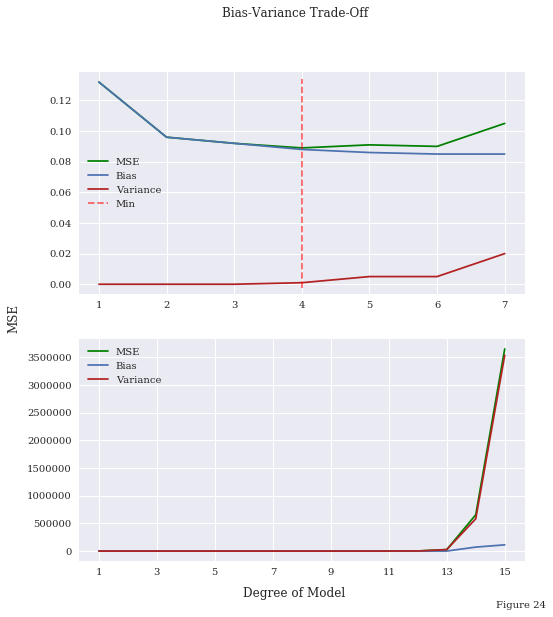

In [51]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,9))
fig.suptitle('Bias-Variance Trade-Off')

ax1.plot(deg[0:7], Bp.iloc[0:7, 0], label='MSE', c = "green")
ax1.plot(deg[0:7], Bp.iloc[0:7, 1], label='Bias')
ax1.plot(deg[0:7], Bp.iloc[0:7, 2], label='Variance', c = "firebrick")
ax1.axvline(x = Bp["Error - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax2.plot(deg, Bp["Error - OLS"], label='MSE', c = "green")
ax2.plot(deg, Bp["Bias - OLS"], label='Bias')
ax2.plot(deg, Bp["Variance - OLS"], label='Variance', c = "firebrick")
ax2.set_xticks(np.arange(1, 16, 2))

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "large")
fig.text(0.001, 0.5, 'MSE', va='center', rotation='vertical', size = "large")
fig.text(0.85, 0.05, 'Figure 24', va="bottom", size = "medium")

ax1.legend()
ax2.legend(loc="upper left")   

We can see that if we apply the bootstrap resampling technique the best model is the model of forth degree beacuse it has the lowest $MSE$, which splits into a very low bias and variance. This means that if we were to use a different training set, the model wouldn't suffer from any relevant changes. Moreover we see how the variance, and consequently the error, increases abruptly after the thirteenth degree polynomial. This is a clear example of overfitting, where we have lower bias and very high variance, which results into having complex models that change a lot based on the training sets used to estimate them.

The results we get are different from the previous ones (in Figure 23) beacuse now we have used a resampling technique (Bootstrap), which should provide more reliable results, since it's like we have 100 different training and test sets and we compute our statistics for every one of them and then compute a mean. 

### OLS with Cross-Validation 

Now we'll do the same, but using anothe resampling technique, the Cross-Validation.

In [52]:
maxdegree = 16
CVp = np.zeros((maxdegree, 2))

kfold5 = KFold(n_splits = 5)
kfold10 = KFold(n_splits = 10)
scores5p = np.zeros((maxdegree, 5))
scores10p = np.zeros((maxdegree, 10))

for degree in range(1, maxdegree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    lin_reg = LinearRegression()
    j = 0
    for train_inds, test_inds in kfold5.split(Xp):
        xtrain_p = Xp[train_inds, :]
        ztrain_p = zp[train_inds]

        xtest_p= Xp[test_inds, :]
        ztest_p= zp[test_inds]

        Xp_train = poly.fit_transform(xtrain_p)
        lin_reg.fit(Xp_train, ztrain_p)
        
        Xp_test = poly.fit_transform(xtest_p)
        zpred_cvp = lin_reg.predict(Xp_test)

        scores5p[degree, j] = MSE(zpred_cvp, ztest_p)

        j += 1

estimated_mse5p = np.mean(scores5p, axis = 1)

CVp = pd.DataFrame(CVp)
CVp.iloc[:, 0] = estimated_mse5p
CVp.columns = ["MSE_5fold - OLS", "MSE_10fold - OLS"]
CVp = CVp.drop(0)
CVp.index = np.arange(1, 16)

for degree in range(1, maxdegree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    lin_reg = LinearRegression()
    j = 0
    for train_inds, test_inds in kfold10.split(Xp):
        xtrain_p = Xp[train_inds, :]
        ztrain_p = zp[train_inds]

        xtest_p= Xp[test_inds, :]
        ztest_p= zp[test_inds]

        Xp_train = poly.fit_transform(xtrain_p)
        lin_reg.fit(Xp_train, ztrain_p)
        
        Xp_test = poly.fit_transform(xtest_p)
        zpred_cvp = lin_reg.predict(Xp_test)

        scores10p[degree, j] = MSE(zpred_cvp, ztest_p)

        j += 1

estimated_mse10p = np.mean(scores10p, axis = 1)

CVp["MSE_10fold - OLS"] = estimated_mse10p[1:16]
display(CVp.round(3))  

,MSE_5fold - OLS,MSE_10fold - OLS
1,0.134,0.131
2,0.087,0.086
3,0.083,0.081
4,0.073,0.072
5,0.075,0.072
6,0.070,0.068
7,0.073,0.069
8,0.081,0.080
9,0.179,0.171
10,0.196,0.113


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


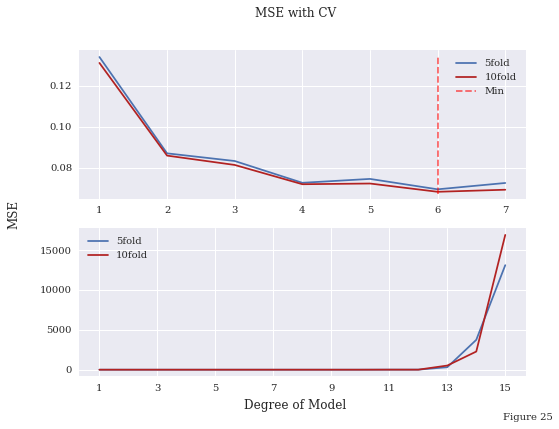

In [53]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,6))
fig.suptitle('MSE with CV')

ax1.plot(deg[0:7], CVp.iloc[0:7, 0], label = "5fold")
ax1.plot(deg[0:7], CVp.iloc[0:7, 1], label = "10fold", c = "firebrick")
ax1.axvline(x = CVp["MSE_10fold - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax2.plot(deg, CVp["MSE_5fold - OLS"], label = "5fold")
ax2.plot(deg, CVp["MSE_10fold - OLS"], label = "10fold", c = "firebrick")
ax2.set_xticks(np.arange(1, 16, 2))

fig.text(0.5, 0.05, 'Degree of Model', ha='center', size = "large")
fig.text(0.0001, 0.5, 'MSE', va='center', rotation='vertical', size = "large")
fig.text(0.86, 0.02, 'Figure 25', va="bottom", size = "medium")

ax1.legend()
ax2.legend() 

We just performed a Cross-Validation estimating the $MSE$ for each model going up to the fifteenth degree, and we can see that for the models up to tenth degree the two different approaches (5-fold and 10-fold) give pretty much the same results, whereas starting from the forteenth degree model the 10-fold Cross-Validation gives $MSE$ values noticebly bigger than the 5-fold Cross-Validation, even though they keep exchanging themselves when it comes to decide which technique is best. Both of them, anyways, suggest the same model as the best one, which end up being the sixth degree model.

,MSE Bootstrap - OLS,MSE_5fold - OLS,MSE_10fold - OLS
1,0.132,0.134,0.131
2,0.096,0.087,0.086
3,0.092,0.083,0.081
4,0.089,0.073,0.072
5,0.091,0.075,0.072
6,0.090,0.070,0.068
7,0.105,0.073,0.069
8,1.191,0.081,0.080
9,4.336,0.179,0.171
10,86.011,0.196,0.113


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


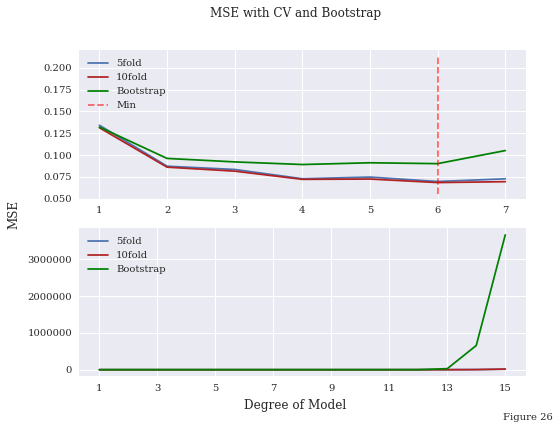

In [54]:
COMPp = np.stack((Bp["Error - OLS"], CVp["MSE_5fold - OLS"], CVp["MSE_10fold - OLS"]), axis = -1)
COMPp = pd.DataFrame(COMPp)
COMPp = COMPp.round(3) 
COMPp.columns = ["MSE Bootstrap - OLS", "MSE_5fold - OLS", "MSE_10fold - OLS"]
COMPp.index = np.arange(1, 16)   
display(COMPp)

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,6))
fig.suptitle('MSE with CV and Bootstrap')

ax1.plot(deg[0:7], CVp.iloc[0:7, 0], label = "5fold")
ax1.plot(deg[0:7], CVp.iloc[0:7, 1], label = "10fold", c = "firebrick")
ax1.plot(deg[0:7], Bp.iloc[0:7, 0], label = "Bootstrap", c = "green")
ax1.axvline(x = COMPp["MSE_10fold - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax1.set_ylim(0.05, 0.22)

ax2.plot(deg, CVp["MSE_5fold - OLS"], label =  "5fold")
ax2.plot(deg, CVp["MSE_10fold - OLS"], label =  "10fold", c = "firebrick")
ax2.plot(deg, Bp["Error - OLS"], c = "green",  label = "Bootstrap")
ax2.set_xticks(np.arange(1, 16, 2))

fig.text(0.5, 0.05, 'Degree of Model', ha='center', size = "large")
fig.text(0.0001, 0.5, 'MSE', va='center', rotation='vertical', size = "large")
fig.text(0.86, 0.02, 'Figure 26', va="bottom", size = "medium")

ax1.legend()
ax2.legend()

Here we have a comparison between the $MSE$ for each of the models up to fifteenth degree order that we estimated using three different ways of resampling techniques: 5-fold Cross-Validation, 10-fold Cross-Validation and Bootstrap. Depending on what our necessities and aims in the analysis are, we should use a different resampling method, since the bootstrap and the Cross-Validation have completely different approches and it is not unlikely for them to provide different outcomes.
In this case, the Bootstrap recognises as best model (the one with the samllest $MSE$, which means the one whose predictions are the closest to the real data) the forth degree order model (as seen in Figure 24), whereas both the Cross-Validation approches find the sixth degree model to be the best.  
We can see, however, that the $MSE$ values obtained with the Bootstrap method are always higher than the ones obtained with the Cross-Validation, especially as the complexity of the model increases.

### Ridge Regression

Cross-Validation is widely used to select the tuning parameters, here being $\lambda$ for the Ridge Regression. For each $\lambda \in [10^{-4}, 10^4]$ we compute a 5-fold Cross-Validation and calculate the $MSE$ and for each of the 100 $\lambda$ taken into consideration we look for the one that produces the smallest $MSE$. 

In [55]:
nlambdas = 100
lambdas = np.logspace(-4, 4, nlambdas)

maxdegree = 16
k = 5
kfold_r = KFold(n_splits = k)
estimated_mse_rp = np.zeros((maxdegree, nlambdas))
bestlambda_rp = np.zeros(maxdegree)
mse_rp = np.zeros(maxdegree)

for degree in range(1, maxdegree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xftp = poly.fit_transform(Xp)

    i = 0
    minim = float("inf")
    for lmb in lambdas:
        ridge = Ridge(alpha = lmb, normalize = True)
        estimated_mse_folds = cross_val_score(ridge, Xftp, zp, scoring='neg_mean_squared_error', cv=kfold_r)
        estimated_mse_rp[degree, i] = np.mean(- estimated_mse_folds)
        if estimated_mse_rp[degree, i] < minim:
            bestlambda_rp[degree] = lmb
            minim = estimated_mse_rp[degree, i]
            mse_rp[degree] = estimated_mse_rp[degree, i]
        i += 1
    
LRp = np.stack((bestlambda_rp, mse_rp), axis = -1)
LRp = pd.DataFrame(LRp)
LRp = LRp.drop(0)
LRp = LRp.round(4) 
LRp.columns = ["Best Lambda", "Min MSE"]
LRp.index = np.arange(1, 16)   
display(LRp)

,Best Lambda,Min MSE
1,0.0320,0.1334
2,0.0011,0.0870
3,0.0006,0.0833
4,0.0001,0.0730
5,0.0001,0.0734
6,0.0001,0.0693
7,0.0001,0.0702
8,0.0005,0.0716
9,0.0016,0.0731
10,0.0001,0.0741


Text(0.5, 0.98, 'Best Lambda for Each Model')

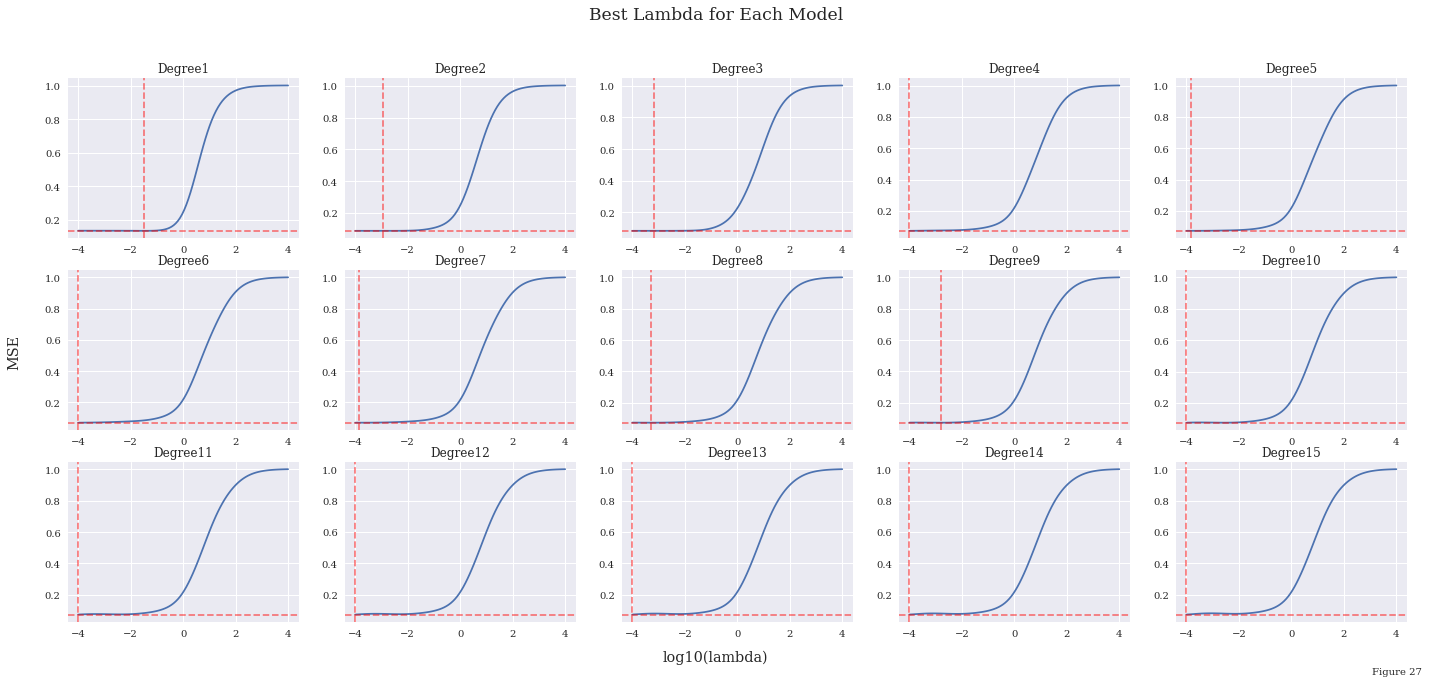

In [56]:
fig, ax = plt.subplots(3,5, figsize=(24, 10))
ax = ax.ravel()
for i in range(1, 16):
    ax[i - 1].plot(np.log10(lambdas), estimated_mse_rp[i, :])
    ax[i - 1].axvline(x=(np.log10(bestlambda_rp[i])), c= "red", linestyle = "--", alpha = 0.5)
    ax[i - 1].axhline(y = LRp.iloc[i-1, 1], c= "red", linestyle = "--", alpha = 0.5)
    ax[i - 1].set_title("Degree" + str(deg[i-1]))
fig.text(0.88, 0.05, 'Figure 27', va="bottom", size = "medium")
fig.text(0.09, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.5, 0.07,'log10(lambda)', ha="center", size = "x-large")
fig.suptitle("Best Lambda for Each Model", size = "xx-large")

Here we have 15 graphics showing the $MSE$ for all of the $\lambda$ values we took into account. We can see that, as the value of $\lambda$ increases, the $MSE$ increases as well. As we have already said, we know that for higher values of $\lambda$ the paramaters $\beta$ go through a heavier shrinkage, so we have models that don't really fit to the data, since a lot of the parameters are very close to zero.

Now let's perform a Ridge Regression on the fifth degree polynomial we already used for the OLS Regression and to do so we use the best $\lambda$ we found with the Cross-Validation: 0.0001

,R2 - OLS,MSE - OLS,R2-Ridge,MSE-Ridge
Training,0.933620,0.066380,0.933169,0.066831
Test,0.926215,0.075127,0.927812,0.073501


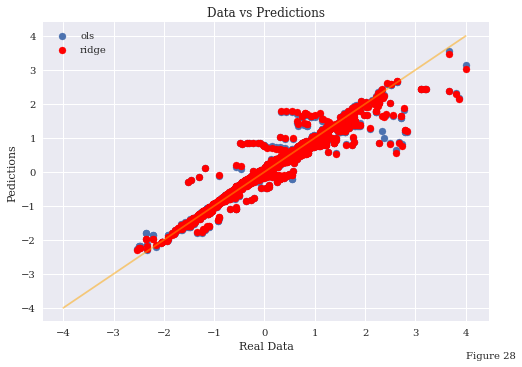

In [57]:
I = np.eye(20,20)
lambda_rp = 0.0001
beta5_rp = np.linalg.inv(X5p_train.T.dot(X5p_train)+lambda_rp*I).dot(X5p_train.T).dot(z5p_train)
ztilde5_rp = X5p_train @ beta5_rp
zpred5_rp = X5p_test @ beta5_rp

Gp["R2-Ridge"] = [R2(z5p_train, ztilde5_rp), R2(z5p_test, zpred5_rp)]
Gp["MSE-Ridge"] = [MSE(z5p_train, ztilde5_rp), MSE(z5p_test, zpred5_rp)]
display(Gp.iloc[:, [2,3,4,5]])

plt.scatter(z5p_test, zpred5p, label= "ols")
plt.scatter(z5p_test, zpred5_rp, label="ridge", c="red")
plt.plot([-4, 4], [-4, 4], c = "orange", alpha = 0.5)
plt.xlabel("Real Data")
plt.ylabel("Pedictions")
plt.title("Data vs Predictions")
plt.text(4, -5.53, 'Figure 28', va="bottom", size = "medium")
plt.legend()

If we compare it to the OLS regression, we can see that we get a slightly better fit, with an $R^2 = 92,7\%$, which means $92,7\%$ of the variance of the test set explained by the model. Also from the figure it is noticeable that the previsions made with the Ridge Regression are a little bit closer to the bisector of the first and third quadrant than the OLS predictions, but it is a very minimal difference. 

### Confidence Intervals
Let's compute the 95% confidence intervals of the $\beta$ parameters and see how much they shrunk compared to the ones we obtained with the OLS regression.

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Lower,-603.572258,-521.422700,-2074.041844,-4366.005724,-2502.908686,-4767.999752,-11764.316371,-15220.128426,-7751.816630,-4008.875112,-14556.071289,-27235.311338,-27246.776568,-11702.473253,-3209.420098,-13405.718656,-22711.641903,-24031.376852,-17843.786603,0.000000
Beta,-0.074562,-6.090206,17.714156,-24.353006,39.510138,-19.166090,-25.186315,68.058472,-79.151490,2.158048,56.682652,-63.835658,0.508468,45.049012,14.414366,-62.410708,62.791369,-9.923721,-13.672367,-2.164617
Upper,603.423133,509.242287,2109.470156,4317.299711,2581.928962,4729.667573,11713.943742,15356.245369,7593.513651,4013.191208,14669.436592,27107.640022,27247.793504,11792.571276,3238.248831,13280.897240,22837.224641,24011.529410,17816.441869,0.000000
Se,307.906987,262.924742,1067.222449,2215.128937,1297.152461,2422.874318,5989.352070,7800.095356,3914.625072,2046.445490,7455.486704,13862.997796,13901.676039,5993.633808,1644.813502,6807.810178,11619.608812,12255.843434,9096.997059,3422.028468


Text(20, -250, 'Figure 29')

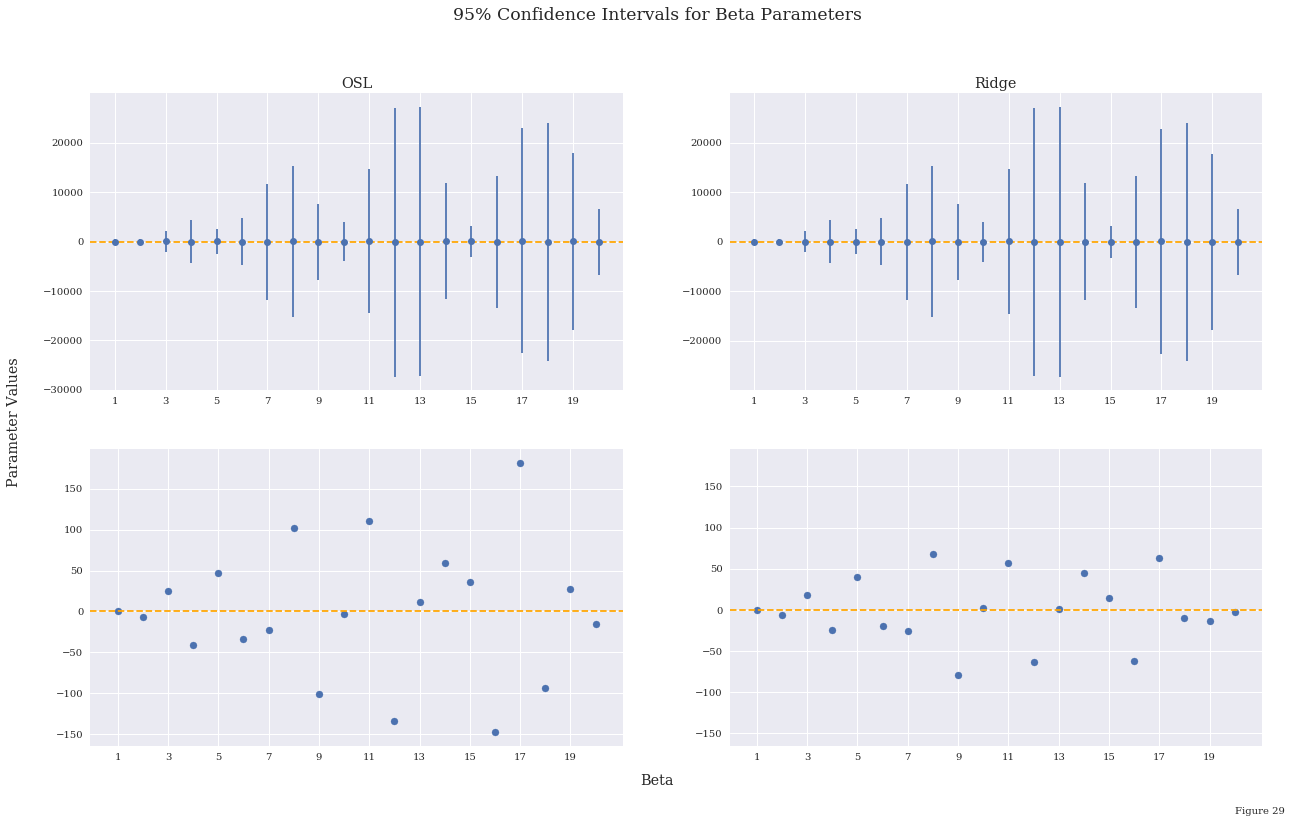

In [59]:
se_rp = sefunction(z5p_train, X5p_train, beta5_rp)
interval_rp = conffunction(beta5_rp, se_rp)

beta5_rp = beta5_rp.reshape(20)
INp_r = np.vstack((interval_rp[:, 0], beta5_rp, interval_rp[:, 1], se_rp))
INp_r = pd.DataFrame(INp_r)              
INp_r.index = ["Lower", "Beta", "Upper", "Se"] 
INp_r.columns = np.arange(1, 21)
display(INp_r)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(21, 12))
fig.suptitle('95% Confidence Intervals for Beta Parameters', size = "xx-large")

ax1.set_xticks(np.arange(1,21, 2))
ax1.axhline(np.mean(beta5p), c="orange", linestyle= "--")
ax1.errorbar(x = np.arange(1, 21, 1), y = beta5p, yerr = (1.96*se_p), fmt='o')
ax1.set_title("OSL", size = "x-large")

ax2.set_xticks(np.arange(1,21, 2))
ax2.axhline(np.mean(beta5_rp), c="orange", linestyle= "--")
ax2.errorbar(x = np.arange(1, 21, 1), y = beta5_rp, yerr = (1.96*se_rp), fmt='o')
ax2.set_title("Ridge", size = "x-large")

ax3.set_xticks(np.arange(1,21, 2))
ax3.axhline(np.mean(beta5p), c="orange", linestyle= "--")
ax3.scatter(x = np.arange(1, 21, 1), y = beta5p)

ax4.set_xticks(np.arange(1,21, 2))
ax4.set_ylim(-165, 195)
ax4.axhline(np.mean(beta5_rp), c="orange", linestyle= "--")
ax4.scatter(x = np.arange(1, 21, 1), y = beta5_rp)

fig.text(0.5, 0.08, 'Beta', ha='center', size = "x-large")
fig.text(0.07, 0.5, 'Parameter Values', va='center', rotation='vertical', size = "x-large")
plt.text(20, -250, 'Figure 29', va="bottom", size = "medium")

The parameters' variance didn't decrease, but stayed pretty much the same, meaning that the intervals didn't become more accurate, but the $\beta$ values got closer to zero.

### Ridge with Bootstrap Resampling
We will perform now the same Ridge Regression, but applying the Bootstrap resampling in order to select the best model among the first 15 polynomials.

In [60]:
np.random.seed(1006)
Xp_train, Xp_test, zp_train, zp_test = train_test_split(Xp, zp, test_size=0.2)

np.random.seed(18)
n_boostraps = 100
maxdegree = 16

error_p = np.zeros((maxdegree, 1))
bias_p = np.zeros((maxdegree, 1))
variance_p = np.zeros((maxdegree, 1))

zpred_rp = np.zeros((zp_test.shape[0], n_boostraps)) 
    
for degree in range(1,maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), Ridge(alpha = bestlambda_rp[degree], normalize = True))
    
    for i in range(n_boostraps):
        x_, y_ = resample(Xp_train, zp_train)
        zpred_rp[:, i] = model.fit(x_, y_).predict(Xp_test).ravel()
    error_p[degree] = np.mean(np.mean((zp_test - zpred_rp)**2, axis=1, keepdims=True) )
    bias_p[degree] = np.mean((zp_test - np.mean(zpred_rp, axis=1, keepdims=True))**2 )
    variance_p[degree] = np.mean(np.var(zpred_rp, axis=1, keepdims=True) )

Bp["Error - Ridge"] = error_p[1:16, :]
Bp["Bias - Ridge"] = bias_p[1:16, :]
Bp["Variance - Ridge"] = variance_p[1:16, :]   
Bp = Bp.round(3)
display(Bp)

,Error - OLS,Bias - OLS,Variance - OLS,Error - Ridge,Bias - Ridge,Variance - Ridge
1,0.132,0.132,0.000,0.134,0.134,0.000
2,0.096,0.096,0.000,0.096,0.096,0.000
3,0.092,0.092,0.000,0.092,0.092,0.000
4,0.089,0.088,0.001,0.088,0.087,0.001
5,0.091,0.086,0.005,0.090,0.086,0.004
6,0.090,0.085,0.005,0.094,0.083,0.011
7,0.105,0.085,0.020,0.088,0.083,0.005
8,1.191,0.197,0.994,0.089,0.083,0.006
9,4.336,0.396,3.940,0.088,0.083,0.004
10,86.011,6.459,79.552,0.410,0.106,0.304


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


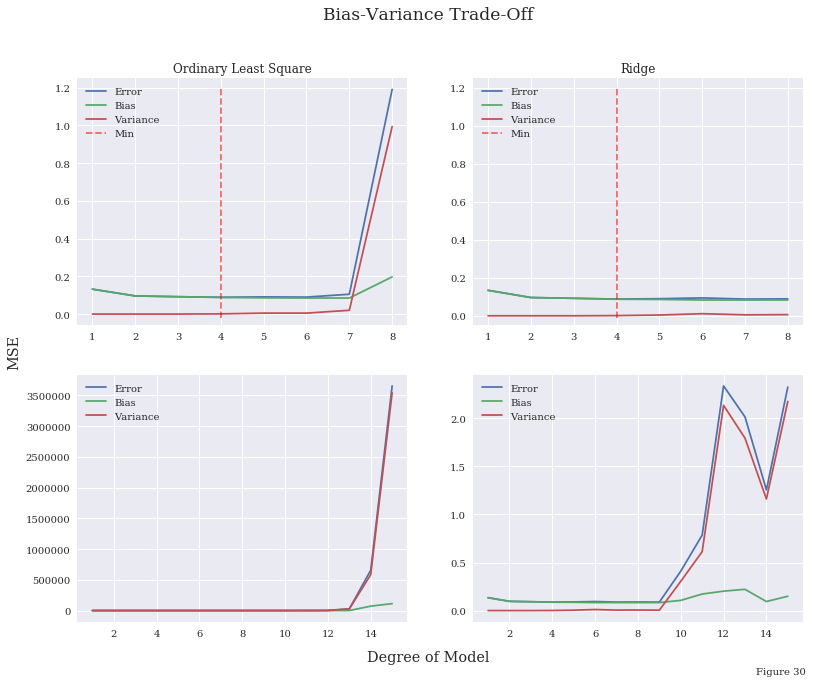

In [61]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(13, 10))
fig.suptitle('Bias-Variance Trade-Off', size = "xx-large")

ax1.plot(deg[0:8], Bp.iloc[0:8, 0], label='Error')
ax1.plot(deg[0:8], Bp.iloc[0:8, 1], label='Bias')
ax1.plot(deg[0:8], Bp.iloc[0:8, 2], label='Variance')
ax1.axvline(x = Bp["Error - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax2.plot(deg[0:8], Bp.iloc[0:8, 3], label='Error')
ax2.plot(deg[0:8], Bp.iloc[0:8, 4], label='Bias')
ax2.plot(deg[0:8], Bp.iloc[0:8, 5], label='Variance')
ax2.axvline(x = Bp["Error - Ridge"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax2.set_ylim(-0.05, 1.25)

ax3.plot(deg, Bp["Error - OLS"], label='Error')
ax3.plot(deg, Bp["Bias - OLS"], label='Bias')
ax3.plot(deg, Bp["Variance - OLS"], label='Variance')

ax4.plot(deg, Bp["Error - Ridge"], label='Error')
ax4.plot(deg, Bp["Bias - Ridge"], label='Bias')
ax4.plot(deg, Bp["Variance - Ridge"], label='Variance')

ax1.set_title("Ordinary Least Square") 
ax2.set_title("Ridge")

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "x-large")
fig.text(0.05, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.85, 0.05, 'Figure 30', va="bottom", size = "medium")

ax1.legend()
ax2.legend(loc="upper left")   
ax3.legend()
ax4.legend()   

It is immediately obvious the difference in $MSE$ values between the two Regression methods: the Ridge method produces a lower $MSE$ starting from the seventh degree polynomial and the difference becomes pretty consistant as the complexity of the model increases. For the 15th degree model we have an error of over 3 million for the OLS Regression and 2.32 for the Ridge Regression. 
We can also see that in the OLS Regression the error and the variance increase way faster than in the Ridge Regression, that is because in the OLS Regression the $\beta$ parameters are not forced to go towards zero, so in complex models we find many parameters which bring the model to overfit. In the Ridge Regression, on the other hand, many parameters (as we have seen in the Figure 29) are forced to shrink, which means that their contribution to the model is very little and the test data can be predicted more easily no matter which training set we use.

### Ridge with Cross-Validation

We now perform a Cross-Validation with the same previous purpose. We'll do again a 5-fold cross-validation and a 10-fold.

In [63]:
mean5_rp = np.zeros(maxdegree)
mean10_rp = np.zeros(maxdegree)

kfold5 = KFold(n_splits = 5)
kfold10 = KFold(n_splits = 10)
kfold = [kfold5, kfold10]

for i in (0, 1):
    for degree in range(1, maxdegree):
        polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
        ridge =  Ridge(alpha = bestlambda_rp[degree], normalize = True)
        pipeline = Pipeline([("polynomial_features", polynomial_features), ("ridge", ridge)])
        pipeline.fit(Xp, zp)

        scores = cross_val_score(pipeline, Xp, zp, scoring="neg_mean_squared_error", cv=kfold[i])
        if i == 0:
            mean5_rp[degree] = -scores.mean()
        else: 
            mean10_rp[degree] = - scores.mean() 

CVp["MSE_5fold - Ridge"] = mean5_rp[1:]
CVp["MSE_10fold - Ridge"] = mean10_rp[1:]

COMPp["MSE Bootstrap - Ridge"] = Bp["Error - Ridge"]
COMPp["MSE_5fold - Ridge"] = CVp["MSE_5fold - Ridge"]
COMPp["MSE_10fold - Ridge"] = CVp["MSE_10fold - Ridge"]  
display(COMPp.round(3))

,MSE Bootstrap - OLS,MSE_5fold - OLS,MSE_10fold - OLS,MSE Bootstrap - Ridge,MSE_5fold - Ridge,MSE_10fold - Ridge
1,0.132,0.134,0.131,0.134,0.133,0.131
2,0.096,0.087,0.086,0.096,0.087,0.086
3,0.092,0.083,0.081,0.092,0.083,0.081
4,0.089,0.073,0.072,0.088,0.073,0.072
5,0.091,0.075,0.072,0.090,0.073,0.071
6,0.090,0.070,0.068,0.094,0.069,0.068
7,0.105,0.073,0.069,0.088,0.070,0.068
8,1.191,0.081,0.080,0.089,0.072,0.070
9,4.336,0.179,0.171,0.088,0.073,0.071
10,86.011,0.196,0.113,0.410,0.074,0.072


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


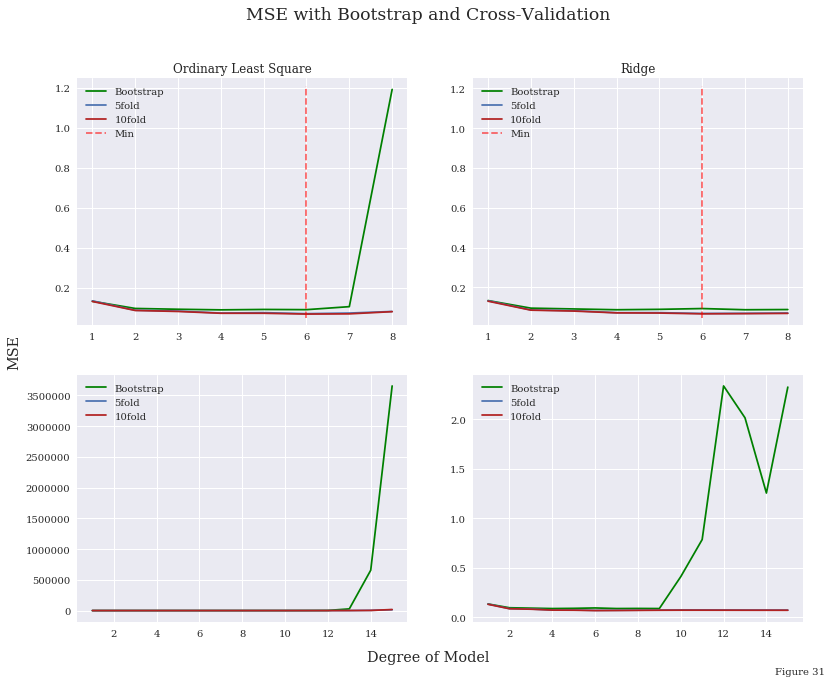

In [64]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(13,10))
fig.suptitle('MSE with Bootstrap and Cross-Validation', size = "xx-large")

ax1.plot(deg[0:8], COMPp.iloc[0:8, 0], label = "Bootstrap", c = "green")
ax1.plot(deg[0:8], COMPp.iloc[0:8, 1], label = "5fold")
ax1.plot(deg[0:8], COMPp.iloc[0:8, 2], label = "10fold", c = "firebrick")
ax1.axvline(x = COMPp["MSE_10fold - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax2.plot(deg[0:8], COMPp.iloc[0:8, 3], label = "Bootstrap", c = "green")
ax2.plot(deg[0:8], COMPp.iloc[0:8, 4], label = "5fold")
ax2.plot(deg[0:8], COMPp.iloc[0:8, 5], label = "10fold", c = "firebrick")
ax2.axvline(x = COMPp["MSE_10fold - Ridge"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax2.set_ylim(0.01, 1.25)

ax3.plot(deg, COMPp["MSE Bootstrap - OLS"], label = "Bootstrap", c = "green")
ax3.plot(deg, COMPp["MSE_5fold - OLS"], label = "5fold")
ax3.plot(deg, COMPp["MSE_10fold - OLS"], label = "10fold", c = "firebrick")

ax4.plot(deg, COMPp["MSE Bootstrap - Ridge"], label = "Bootstrap", c = "green")
ax4.plot(deg, COMPp["MSE_5fold - Ridge"], label = "5fold")
ax4.plot(deg, COMPp["MSE_10fold - Ridge"], label = "10fold", c = "firebrick")

ax1.set_title("Ordinary Least Square") 
ax2.set_title("Ridge")

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "x-large")
fig.text(0.05, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.87, 0.05, 'Figure 31', va="bottom", size = "medium")

ax1.legend(loc= "upper left")
ax2.legend(loc= "upper left")   
ax3.legend(loc= "upper left")
ax4.legend(loc= "upper left")

If we look both at Bootstrap and the Cross-Validation we notice that for the models with a lower degree order there's no difference between the two Regression methods, whereas the difference is noticeable for higher degree polynomials. The reason is the same as before: the shrinkage towards zero of many of the $\beta$ parameters.   


### Lasso Regression

Let's now use the Cross-Validation to select the best $\lambda$ for the Lasso Regression computing a 5-fold Cross-Validation and calculating the $MSE$ for each of the $\lambda \in [10^{-4}, 10^4]$.

In [65]:
nlambdas = 100
lambdas = np.logspace(-4, 4, nlambdas)

maxdegree = 16
k = 5
kfold_lp = KFold(n_splits = k)
estimated_mse_lp = np.zeros((maxdegree, nlambdas))
bestlambda_lp = np.zeros(maxdegree)
mse_lp = np.zeros(maxdegree)

for degree in range(1, maxdegree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xftp = poly.fit_transform(Xp)
    i = 0
    minim = float("inf")
    for lmb in lambdas:
        lasso = Lasso(lmb, max_iter = 10000, tol = 0.5)
        estimated_mse_folds = cross_val_score(lasso, Xftp, zp, scoring='neg_mean_squared_error', cv=kfold_lp)
        estimated_mse_lp[degree, i] = np.mean(- estimated_mse_folds)
        if estimated_mse_lp[degree, i] < minim:
            bestlambda_lp[degree] = lmb
            minim = estimated_mse_lp[degree, i]
            mse_lp[degree] = estimated_mse_lp[degree, i]
        i += 1
    
LLp = np.stack((bestlambda_lp, mse_lp), axis = -1)
LLp = pd.DataFrame(LLp)
LLp = LLp.drop(0)
LLp = LLp.round(4) 
LLp.columns = ["Best Lambda", "Min MSE"]
LLp.index = np.arange(1, 16)   
display(LLp)

,Best Lambda,Min MSE
1,0.0811,0.1649
2,0.0673,0.1615
3,0.0464,0.1538
4,0.0464,0.1527
5,0.0464,0.1469
6,0.0464,0.1472
7,0.0559,0.1472
8,0.0464,0.1478
9,0.0464,0.1477
10,0.0464,0.1475


Text(0.5, 0.07, 'log10(lambda)')

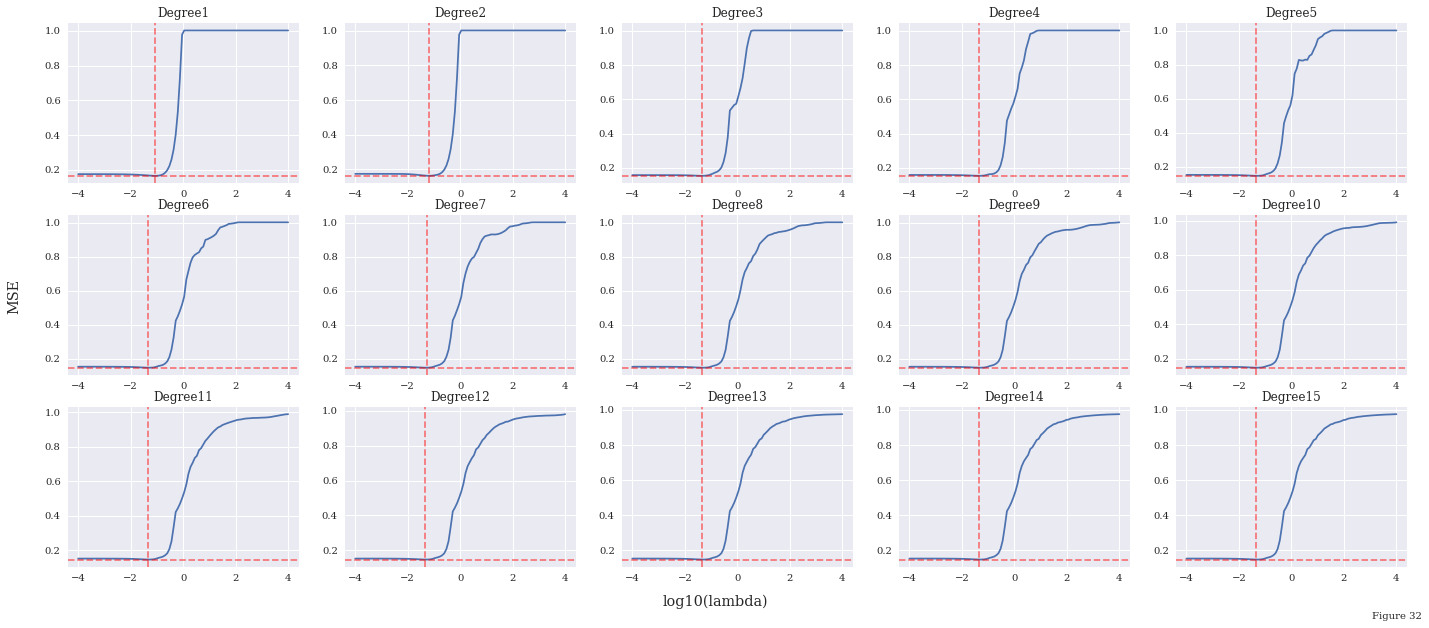

In [66]:
fig, ax = plt.subplots(3,5, figsize=(24, 10))
ax = ax.ravel()
for i in range(1, 16):
    ax[i -1].plot(np.log10(lambdas), estimated_mse_lp[i, :])
    ax[i -1].axvline(x=(np.log10(bestlambda_lp[i])), c= "red", linestyle = "--", alpha = 0.5)
    ax[i -1].axhline(y = LLp.iloc[i-1, 1], c= "red", linestyle = "--", alpha = 0.5)
    ax[i -1].set_title("Degree" + str(deg[i-1]))
fig.text(0.88, 0.05, 'Figure 32', va="bottom", size = "medium")
fig.text(0.09, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.5, 0.07,'log10(lambda)', ha="center", size = "x-large")

Here we have 15 graphics showing the $MSE$ for all of the $\lambda$ values we took into account. We can see that, as the value of $\lambda$ increases, the $MSE$ increases as well, but at a certain point we reach a plateau: this means that all of the parameters $\beta$ are set to zero and therefor the $MSE$ can't increase any further. We know that for higher values of $\lambda$ the paramaters $\beta$ go through a heavier shrinkage until they become zero, so we have models that don't really fit to the data, since a lot of the parameters are not even taken into account.   
We notice, however, that as the complexity increases, the plateau is reached later, because more parameters are needed to give a proper explanation of the data.

Now let's perform a Lasso Regression on the fifth degree polynomial we already used for the OLS and Ridge Regression and to do so we use the best $\lambda$ we found for this model with the Cross-Validation: 0.0464

,R2 - OLS,MSE - OLS,R2-Ridge,MSE-Ridge,R2-Lasso,MSE-Lasso
Training,0.933620,0.066380,0.933169,0.066831,-0.789242,1.789242
Test,0.926215,0.075127,0.927812,0.073501,-0.763197,1.795505


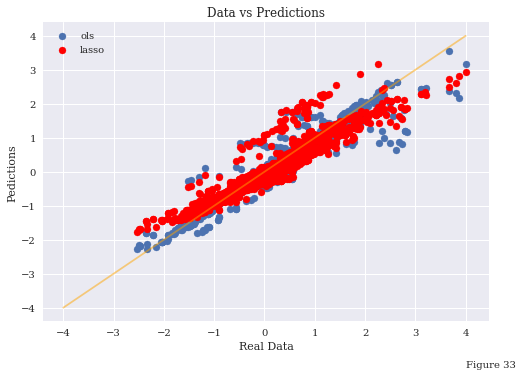

In [67]:
lambda_lp = 0.0464
lasso = Lasso(lambda_lp, max_iter = 8000, tol = 0.06)
lasso.fit(X5p_train, z5p_train)
ztilde5_lp = lasso.predict(X5p_train)
zpred5_lp = lasso.predict(X5p_test)
beta5_lp = lasso.coef_

Gp["R2-Lasso"] = [1 - np.mean((z5p_train - ztilde5_lp)**2) / np.mean((z5p_train - np.mean(ztilde5_lp))**2),
                 1 - np.mean((z5p_test - zpred5_lp)**2) / np.mean((z5p_test - np.mean(zpred5_lp))**2)]
Gp["MSE-Lasso"] = [MSE(z5p_train, ztilde5_lp), MSE(z5p_test, zpred5_lp)]
display(Gp.iloc[:, [2,3,4,5,6,7]])

plt.scatter(z5p_test, zpred5p, label= "ols")
plt.scatter(z5p_test, zpred5_lp, label="lasso", c="red")
plt.plot([-4, 4], [-4, 4], c = "orange", alpha = 0.5)
plt.xlabel("Real Data")
plt.ylabel("Pedictions")
plt.title("Data vs Predictions")
plt.text(4, -5.8, 'Figure 33', va="bottom", size = "medium")
plt.legend()

If we compare the fit of the model obtained with Lasso to the one obtained with OLS, we can see that we get a completely different output: with Lasso the $R^2$ is negative and the test $MSE$ is 25 times bigger. We can also see from the graph that the predictions made with Lasso are tilted compared to the bisector of the first and third quadrant.

### Confidence Intervals
Let's compute the $95\%$ confidence intervals of the $\beta$ parameters and see how much they shrunk and how many of them went to zero compared to the ones we obtained with the OLS and Ridge Regression.

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Lower,-580.441007,-495.301859,-2012.947816,-4178.078302,-2446.631644,-4569.918457,-11296.851170,-14712.195129,-7383.592800,-3859.915039,-14062.209521,-26147.773757,-26220.726949,-11304.927196,-3102.374534,-12840.590681,-21916.392604,-23116.430229,-17158.353804,0.000000
Beta,0.319544,0.615169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.009555
Upper,581.080095,496.532196,2012.947816,4178.078302,2446.631644,4569.918457,11296.851170,14712.195129,7383.592800,3859.915039,14062.209521,26147.773757,26220.726949,11304.927196,3102.374534,12840.590681,21916.392604,23116.430229,17158.353804,0.000000
Se,296.306404,253.018891,1027.014192,2131.672603,1248.281451,2331.591050,5763.699576,7506.222005,3767.139184,1969.344407,7174.596694,13340.700896,13377.921913,5767.819998,1582.844150,6551.321776,11181.832961,11794.097056,8754.262145,3293.101458


Text(20, -230, 'Figure 34')

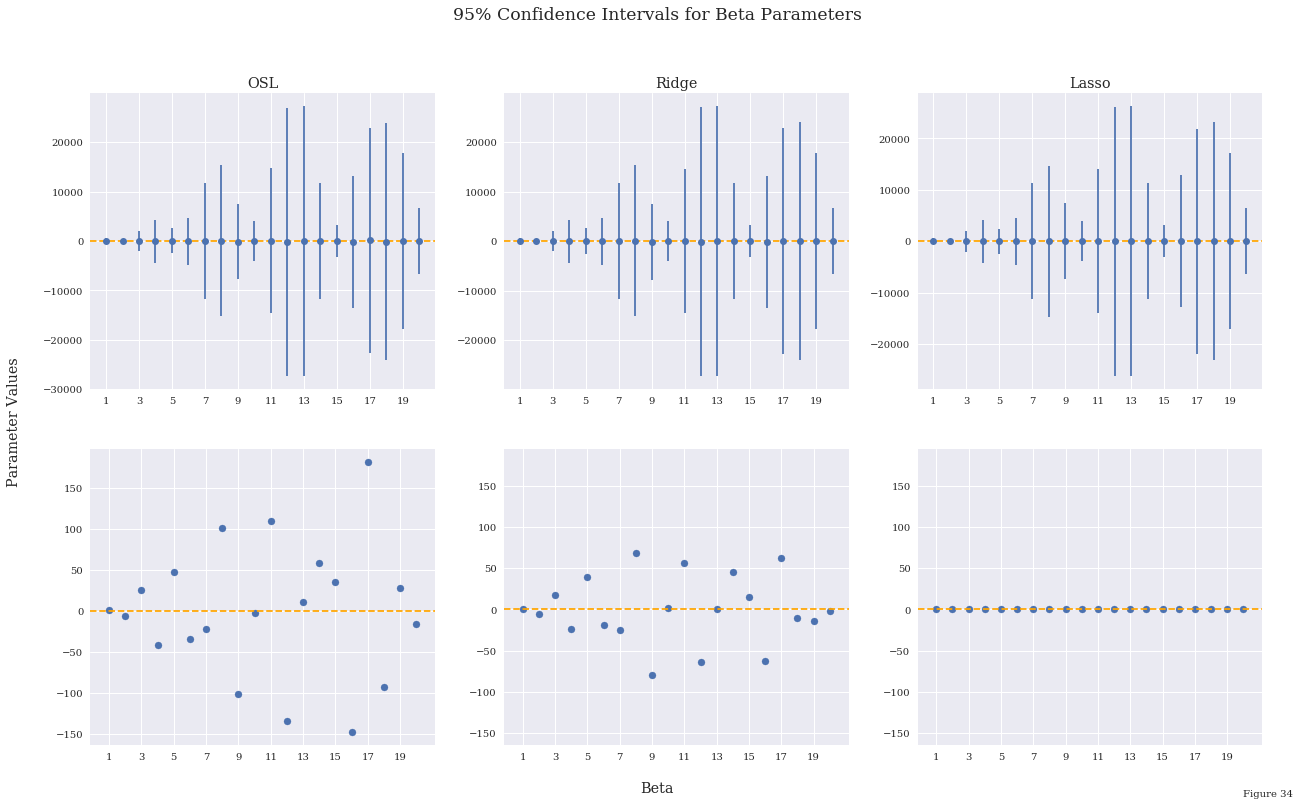

In [71]:
se_lp = sefunction(z5p_train, X5p_train, beta5_lp)
interval_lp = conffunction(beta5_lp, se_lp)

beta5_lp = beta5_lp.reshape(20)
INp_l = np.vstack((interval_lp[:, 0], beta5_lp, interval_lp[:, 1], se_lp))
INp_l = pd.DataFrame(INp_l)              
INp_l.index = ["Lower", "Beta", "Upper", "Se"] 
INp_l.columns = np.arange(1, 21)
display(INp_l)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(21, 12))
fig.suptitle("95% Confidence Intervals for Beta Parameters", size = "xx-large")

ax1.set_xticks(np.arange(1, 21, 2))
ax1.axhline(np.mean(beta5p), c="orange", linestyle= "--")
ax1.errorbar(x = np.arange(1, 21, 1), y = beta5p, yerr = (1.96*se_p), fmt='o')
ax1.set_title("OSL", size = "x-large")

ax2.set_xticks(np.arange(1, 21, 2))
ax2.axhline(np.mean(beta5_rp), c="orange", linestyle= "--")
ax2.errorbar(x = np.arange(1, 21, 1), y = beta5_rp, yerr = (1.96*se_rp), fmt='o')
ax2.set_title("Ridge", size = "x-large")

ax3.set_xticks(np.arange(1, 21, 2))
ax3.axhline(np.mean(beta5_lp), c="orange", linestyle= "--")
ax3.errorbar(x = np.arange(1, 21, 1), y = beta5_lp, yerr = (1.96*se_lp), fmt='o')
ax3.set_title("Lasso", size = "x-large")

ax4.set_xticks(np.arange(1, 21, 2))
ax4.axhline(np.mean(beta5p), c="orange", linestyle= "--")
ax4.scatter(x = np.arange(1, 21, 1), y = beta5p)

ax5.set_xticks(np.arange(1,21, 2))
ax5.set_ylim(-165, 195)
ax5.axhline(np.mean(beta5_rp), c="orange", linestyle= "--")
ax5.scatter(x = np.arange(1, 21, 1), y = beta5_rp)

ax6.set_xticks(np.arange(1, 21, 2))
ax6.set_ylim(-165, 195)
ax6.axhline(np.mean(beta5_lp), c="orange", linestyle= "--")
ax6.scatter(x = np.arange(1, 21, 1), y = beta5_lp)

fig.text(0.5, 0.07, 'Beta', ha='center', size = "x-large")
fig.text(0.07, 0.5, 'Parameter Values', va='center', rotation='vertical', size = "x-large")
plt.text(20, -230, 'Figure 34', va="bottom", size = "medium")

The parameters' variance didn't decrease, but stayed pretty much the same, meaning that the intervals didin't become more accurate. The $\beta$ values, however, got closer to zero also compared to the Ridge parameters. Let's see how many of them are actually equal to zero.

In [72]:
BETAp = np.vstack((beta5p, beta5_rp, beta5_lp))
BETAp = pd.DataFrame(BETAp)
BETAp.index = ["OLS", "Ridge", "Lasso"]
BETAp.columns = np.arange(1, 21, 1)
display(BETAp.round(3))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
OLS,0.931,-6.344,25.283,-41.093,47.12,-33.792,-22.142,101.701,-101.143,-2.896,110.147,-134.533,10.967,58.805,35.688,-147.764,181.791,-93.538,27.437,-15.669
Ridge,-0.075,-6.090,17.714,-24.353,39.51,-19.166,-25.186,68.058,-79.151,2.158,56.683,-63.836,0.508,45.049,14.414,-62.411,62.791,-9.924,-13.672,-2.165
Lasso,0.320,0.615,0.000,0.000,0.00,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.010


Almost all of them are equal to zero! Only 3 out of 20 are not equal to zero. If our $\lambda$ had been larger, even more coefficients would have been equal to zero.

Let's plot the behaviour of the $\beta$ parameters as $\lambda$ changes.

Text(0.87, 0.03, 'Figure 35')

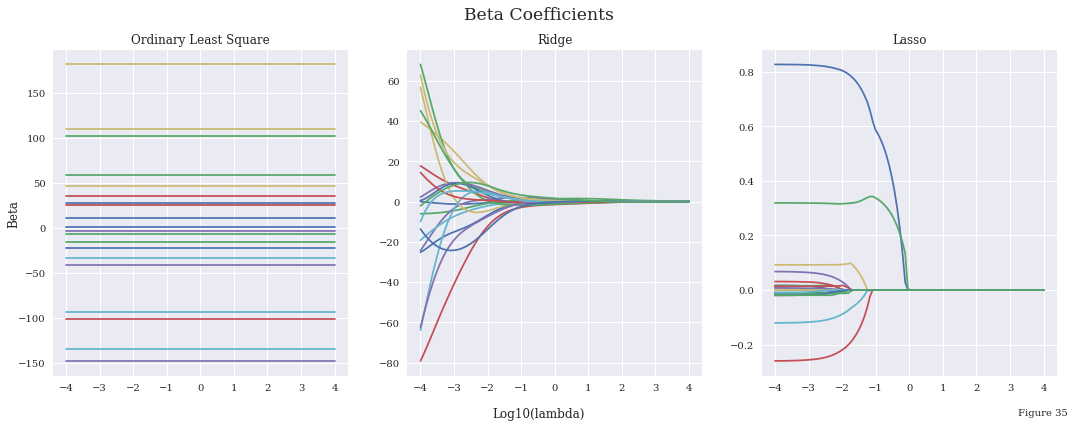

In [70]:
nlambdas = 100
lambdas = np.logspace(-4, 4, nlambdas)
coefsOLS = []
coefsRidge = []
coefsLasso = []

for i in range(100):
    lin = LinearRegression(fit_intercept=False)
    lin.fit(X5p_train, z5p_train)
    coefsOLS.append(lin.coef_[0])
    
    ridge = Ridge(alpha = lambdas[i])
    ridge.fit(X5p_train, z5p_train)
    coefsRidge.append(ridge.coef_[0])
    
    lasso = Lasso(alpha = lambdas[i], max_iter = 6000, tol = 0.5)
    lasso.fit(X5p_train, z5p_train)
    coefsLasso.append(lasso.coef_)
    
    
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
fig.suptitle('Beta Coefficients', size = "xx-large")

ax1.plot(np.log10(lambdas), coefsOLS)
ax1.set_title('Ordinary Least Square')
    
ax2.plot(np.log10(lambdas), coefsRidge)
ax2.set_title('Ridge')

ax3.plot(np.log10(lambdas), coefsLasso)
ax3.set_title('Lasso')

fig.text(0.5, 0.03, 'Log10(lambda)', ha='center', size = "large")
fig.text(0.09, 0.5, 'Beta', va='center', rotation='vertical', size = "large")
fig.text(0.87, 0.03, 'Figure 35', va="bottom", size = "medium")

We can see that of course the coefficients in the Ordinary Least Squares never change. The Ridge and Lasso parameters, on the other hand, shrink towards zero, but we can see how the Ridge $\beta$ continuously shrink, but never really hit zero, whereas the Lasso $\beta$ at a certain point reach zero. We can see that before $\lambda = 1$ already all of the parameters are equal to zero. In the Lasso case, we took $\lambda = 0.0464$ and from the graph we can see that we indeed only have three parameters different from zero.

### Lasso with Bootstrap Resampling 

Now we will perform the same Lasso Regression, but applying the Bootstrap resampling in order to select the best model among the first 15 polynomials.

In [73]:
np.random.seed(18)
n_boostraps = 100
maxdegree = 16

error_lp = np.zeros((maxdegree, 1))
bias_lp = np.zeros((maxdegree, 1))
variance_lp = np.zeros((maxdegree, 1))

zpred_lp = np.zeros((zp_test.shape[0], n_boostraps)) 
    
for degree in range(1,maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), Lasso(bestlambda_lp[degree], max_iter = 2000, tol = 0.4))
    
    for i in range(n_boostraps):
        x_, y_ = resample(Xp_train, zp_train)
        zpred_lp[:, i] = model.fit(x_, y_).predict(Xp_test).ravel()
    error_lp[degree] = np.mean(np.mean((zp_test - zpred_lp)**2, axis=1, keepdims=True) )
    bias_lp[degree] = np.mean((zp_test - np.mean(zpred_lp, axis=1, keepdims=True))**2 )
    variance_lp[degree] = np.mean(np.var(zpred_lp, axis=1, keepdims=True) )

Bp["Error - Lasso"] = error_lp[1:16, :]
Bp["Bias - Lasso"] = bias_lp[1:16, :]
Bp["Variance - Lasso"] = variance_lp[1:16, :]   
Bp = Bp.round(4)
display(Bp)

,Error - OLS,Bias - OLS,Variance - OLS,Error - Ridge,Bias - Ridge,Variance - Ridge,Error - Lasso,Bias - Lasso,Variance - Lasso
1,0.132,0.132,0.000,0.134,0.134,0.000,0.1807,0.1806,0.0001
2,0.096,0.096,0.000,0.096,0.096,0.000,0.1801,0.1799,0.0002
3,0.092,0.092,0.000,0.092,0.092,0.000,0.1681,0.1678,0.0002
4,0.089,0.088,0.001,0.088,0.087,0.001,0.1683,0.1680,0.0003
5,0.091,0.086,0.005,0.090,0.086,0.004,0.1607,0.1604,0.0003
6,0.090,0.085,0.005,0.094,0.083,0.011,0.1604,0.1599,0.0005
7,0.105,0.085,0.020,0.088,0.083,0.005,0.1619,0.1607,0.0012
8,1.191,0.197,0.994,0.089,0.083,0.006,0.1639,0.1609,0.0030
9,4.336,0.396,3.940,0.088,0.083,0.004,0.1656,0.1614,0.0042
10,86.011,6.459,79.552,0.410,0.106,0.304,0.1664,0.1611,0.0053


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


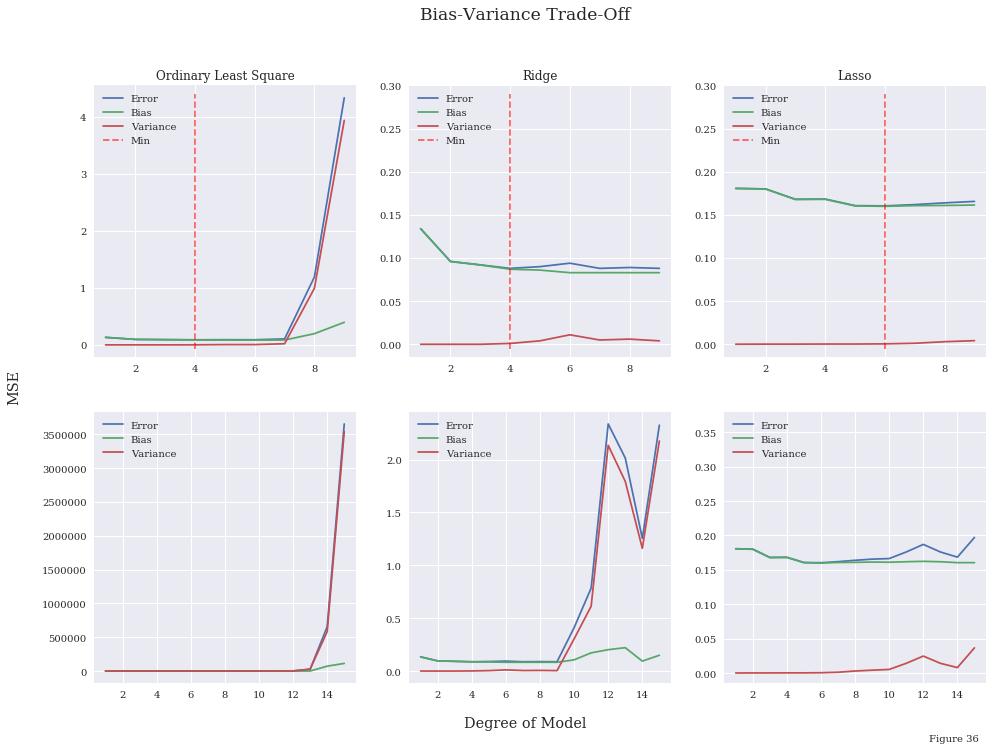

In [74]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,11))
fig.suptitle('Bias-Variance Trade-Off', size = "xx-large")

ax1.plot(deg[0:9], Bp.iloc[0:9, 0], label='Error')
ax1.plot(deg[0:9], Bp.iloc[0:9, 1], label='Bias')
ax1.plot(deg[0:9], Bp.iloc[0:9, 2], label='Variance')
ax1.axvline(x = Bp["Error - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax2.plot(deg[0:9], Bp.iloc[0:9, 3], label='Error')
ax2.plot(deg[0:9], Bp.iloc[0:9, 4], label='Bias')
ax2.plot(deg[0:9], Bp.iloc[0:9, 5], label='Variance')
ax2.axvline(x = Bp["Error - Ridge"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax2.set_ylim(-0.015, 0.3)

ax3.plot(deg[0:9], Bp.iloc[0:9, 6], label='Error')
ax3.plot(deg[0:9], Bp.iloc[0:9, 7], label='Bias')
ax3.plot(deg[0:9], Bp.iloc[0:9, 8], label='Variance')
ax3.axvline(x = Bp["Error - Lasso"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)
ax3.set_ylim(-0.015, 0.3)

ax4.plot(deg, Bp["Error - OLS"], label='Error')
ax4.plot(deg, Bp["Bias - OLS"], label='Bias')
ax4.plot(deg, Bp["Variance - OLS"], label='Variance')

ax5.plot(deg, Bp["Error - Ridge"], label='Error')
ax5.plot(deg, Bp["Bias - Ridge"], label='Bias')
ax5.plot(deg, Bp["Variance - Ridge"], label='Variance')

ax6.plot(deg, Bp["Error - Lasso"], label='Error')
ax6.plot(deg, Bp["Bias - Lasso"], label='Bias')
ax6.plot(deg, Bp["Variance - Lasso"], label='Variance')
ax6.set_ylim(-0.015, 0.38)

ax1.set_title("Ordinary Least Square") 
ax2.set_title("Ridge")
ax3.set_title("Lasso")

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "x-large")
fig.text(0.05, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.85, 0.05, 'Figure 36', va="bottom", size = "medium")


ax1.legend()
ax2.legend(loc="upper left")   
ax3.legend(loc="upper left")
ax4.legend()   
ax5.legend()
ax6.legend(loc="upper left")

It is immediately obvious the difference in $MSE$ values between the three Regression methods, especially between the OSL and the other two. The Ridge and Lasso methods produce an overall lower $MSE$, with the Ridge Regression as the best for the lower degree models and the Lasso for the higher degree models. The difference between the three methods becomes pretty sizable as the complexity of the model increases. For the fifteenth degree model we have an error of more than 3 millions for the OLS Regression, 2.33 for the Ridge Regression and 0.02 for the Lasso Regression. 
We can also see that in the OLS Regression the error and the variance increase way faster than in the Ridge and Lasso, that is because in the OLS Regression the $\beta$ parameters are not forced to go towards zero, so in complex models we still find many parameters which bring the model to overfit. In the Ridge and Lasso Regression, on the other hand, many parameters (as we have seen in the Figure 34 and 35) are forced to shrink (and go to zero in the Lasso case), which means that their contribution to the model is very little (or none) and the test data can be predicted more easily no matter which training set we use.  
We furtermore notice that in the Lasso Regression the error hasn't started to really increase yet, so it will probabbly as the complexity still increases.

### Lasso with Cross-Validation

We now perform a Cross-Validation with the same previous purpose. We'll do again a 5-fold Cross-Validation and a 10-fold.

In [76]:
mean5_lp = np.zeros(maxdegree)
mean10_lp = np.zeros(maxdegree)

kfold5 = KFold(n_splits = 5)
kfold10 = KFold(n_splits = 10)
kfold = [kfold5, kfold10]

for i in (0, 1):
    for degree in range(1, maxdegree):
        polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
        lasso =  Lasso(bestlambda_lp[degree], max_iter = 5000, tol = 0.5)
        pipeline = Pipeline([("polynomial_features", polynomial_features), ("lasso", lasso)])
        pipeline.fit(Xp, zp)

        scores = cross_val_score(pipeline, Xp, zp, scoring="neg_mean_squared_error", cv=kfold[i])
        if i == 0:
            mean5_lp[degree] = -scores.mean()
        else: 
            mean10_lp[degree] = - scores.mean() 

CVp["MSE_5fold - Lasso"] = mean5_lp[1:]
CVp["MSE_10fold - Lasso"] = mean10_lp[1:]

COMPp["MSE Bootstrap - Lasso"] = Bp["Error - Lasso"]
COMPp["MSE_5fold - Lasso"] = CVp["MSE_5fold - Lasso"]
COMPp["MSE_10fold - Lasso"] = CVp["MSE_10fold - Lasso"]  
display(COMPp.round(3))

,MSE Bootstrap - OLS,MSE_5fold - OLS,MSE_10fold - OLS,MSE Bootstrap - Ridge,MSE_5fold - Ridge,MSE_10fold - Ridge,MSE Bootstrap - Lasso,MSE_5fold - Lasso,MSE_10fold - Lasso
1,0.132,0.134,0.131,0.134,0.133,0.131,0.181,0.165,0.164
2,0.096,0.087,0.086,0.096,0.087,0.086,0.180,0.161,0.161
3,0.092,0.083,0.081,0.092,0.083,0.081,0.168,0.154,0.152
4,0.089,0.073,0.072,0.088,0.073,0.072,0.168,0.153,0.152
5,0.091,0.075,0.072,0.090,0.073,0.071,0.161,0.147,0.146
6,0.090,0.070,0.068,0.094,0.069,0.068,0.160,0.147,0.146
7,0.105,0.073,0.069,0.088,0.070,0.068,0.162,0.147,0.146
8,1.191,0.081,0.080,0.089,0.072,0.070,0.164,0.148,0.147
9,4.336,0.179,0.171,0.088,0.073,0.071,0.166,0.148,0.147
10,86.011,0.196,0.113,0.410,0.074,0.072,0.166,0.148,0.147


C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\isabe\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


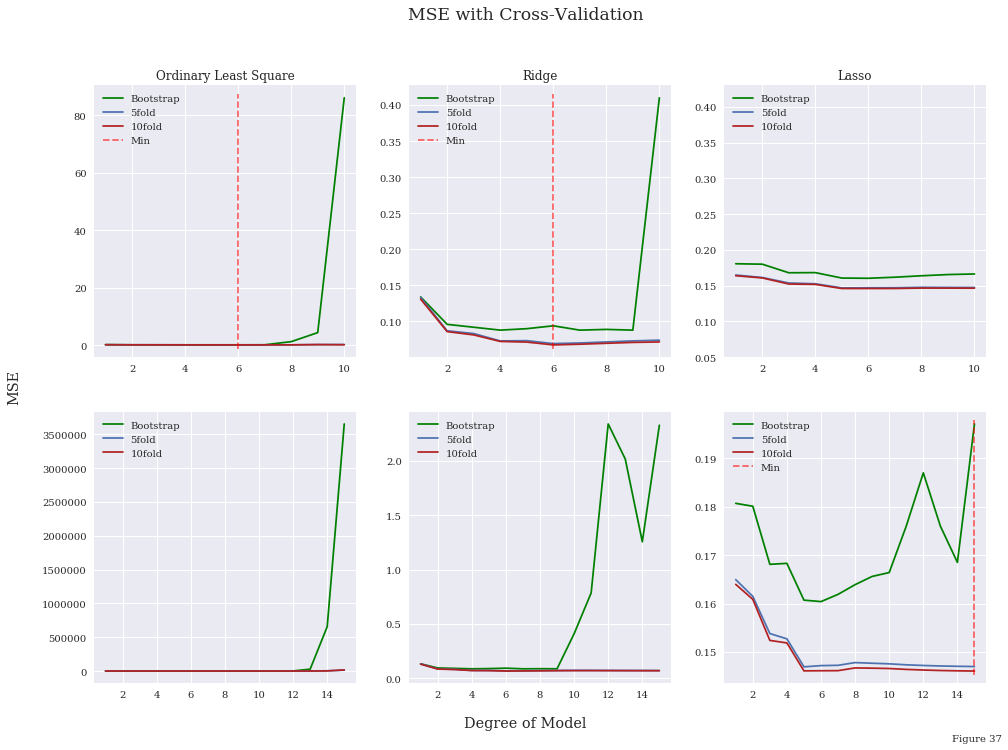

In [77]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,11))
fig.suptitle('MSE with Cross-Validation', size = "xx-large")

ax1.plot(deg[0:10], COMPp.iloc[0:10, 0], label = "Bootstrap", c = "green")
ax1.plot(deg[0:10], COMPp.iloc[0:10, 1], label = "5fold")
ax1.plot(deg[0:10], COMPp.iloc[0:10, 2], label = "10fold", c = "firebrick")
ax1.axvline(x = COMPp["MSE_10fold - OLS"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax2.plot(deg[0:10], COMPp.iloc[0:10, 3], label = "Bootstrap", c = "green")
ax2.plot(deg[0:10], COMPp.iloc[0:10, 4], label = "5fold")
ax2.plot(deg[0:10], COMPp.iloc[0:10, 5], label = "10fold", c = "firebrick")
ax2.axvline(x = COMPp["MSE_10fold - Ridge"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax3.plot(deg[0:10], COMPp.iloc[0:10, 6], label = "Bootstrap", c = "green")
ax3.plot(deg[0:10], COMPp.iloc[0:10, 7], label = "5fold")
ax3.plot(deg[0:10], COMPp.iloc[0:10, 8], label = "10fold", c = "firebrick")
ax3.set_ylim(0.05, 0.43)

ax4.plot(deg, COMPp["MSE Bootstrap - OLS"], label = "Bootstrap", c = "green")
ax4.plot(deg, COMPp["MSE_5fold - OLS"], label = "5fold")
ax4.plot(deg, COMPp["MSE_10fold - OLS"], label = "10fold", c = "firebrick")

ax5.plot(deg, COMPp["MSE Bootstrap - Ridge"], label = "Bootstrap", c = "green")
ax5.plot(deg, COMPp["MSE_5fold - Ridge"], label = "5fold")
ax5.plot(deg, COMPp["MSE_10fold - Ridge"], label = "10fold", c = "firebrick")

ax6.plot(deg, COMPp["MSE Bootstrap - Lasso"], label='Bootstrap', c = "green")
ax6.plot(deg, COMPp["MSE_5fold - Lasso"], label = "5fold")
ax6.plot(deg, COMPp["MSE_10fold - Lasso"], label = "10fold", c = "firebrick")
ax6.axvline(x = COMPp["MSE_10fold - Lasso"].idxmin(), c= "red", linestyle = "--", alpha = 0.6, label = "Min",
            ymin = 0.03, ymax = 0.97)

ax1.set_title("Ordinary Least Square") 
ax2.set_title("Ridge")
ax3.set_title("Lasso")

fig.text(0.5, 0.07, 'Degree of Model', ha='center', size = "x-large")
fig.text(0.05, 0.5, 'MSE', va='center', rotation='vertical', size = "x-large")
fig.text(0.87, 0.05, 'Figure 37', va="bottom", size = "medium")

ax1.legend()
ax2.legend(loc="upper left")   
ax3.legend(loc="upper left")
ax4.legend()   
ax5.legend(loc="upper left")
ax6.legend(loc="upper left")

If we look at the results from the OLS we can see that, as already mentioned, the error is higher comprared to the other two regression methods. If we focus on the Ridge and Lasso, we see that the Bootstrap $MSE$ is always higher, but the $MSE$ we get from the Cross-Validation is smaller in the Ridge Regression for lower degree models and it is smaller in the Lasso Regression for higher degree models. The reason is the same as before: the shrinkage to zero of many of the $\beta$ parameters. However this effect is not as emphasized in the other two resampling methods.